# Credit Card Churning Prediction

This Jupyter Notebook illustrates my working approaches and coding solutions for solving the Credit Card Churning prediction problem, which required Data Scientist to develop a Classification ML model to predict the churn signal for the next 3 months. All datasets available for this problem are divied into 6 csv files, where each file contains differnce types of information such as credit transaction, churning label, etc. Each section of the notebook is divided by each processes taken to develop this Classification ML model, as follows

### Table of Contents
* [1 - Import Libraries](#1)
* [2 - Import Data](#2)
* [3 - Data Exploration](#3)
  * [3.1 - Basic Data Exploration](#3.1)
  * [3.2 - Data Aggregation](#3.2)
  * [3.3 - Exploratory Data Analysis](#3.3)
    * [3.3.1 - Univariate Analysis](#3.3.1)
    * [3.3.2 - Bivariate Analysis](#3.3.2)
* [4 - Data Preprocessing](#4)
  * [4.1 - Dummy Encoding](#4.1)
  * [4.2 - Scaling](#4.2)
  * [4.3 - Train-test Split](#4.3)
  * [4.4 - Over Sampling (SMOTE)](#4.4)
  * [4.5 - Feature Selection](#4.5)
* [5 - Model Training](#5)
  * [5.1 - Logistic Regression](#5.1)
  * [5.2 - Linear SVC](#5.2)
  * [5.3 - Decision Tree Classifier](#5.3)
  * [5.4 - Rendom Forest Classifier](#5.4)
  * [5.5 - XGBoost Classifier](#5.5)
* [6 - Model Prediction](#6)

<a name='1'></a>
# 1 - Import Libraries

Import all library needed for developing the Classifition ML model

In [151]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import itertools
from functools import reduce
from scipy.stats import skew,chi2_contingency, ttest_ind, loguniform, uniform, randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from pipelinehelper import PipelineHelper
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import fbeta_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

<a name='2'></a>
# 2 - Import Data

Import all data available for this problem to further analyzing and developing the ML model

In [2]:
training_data = pd.read_csv(r'..\Data\y_train.csv', sep = ',')
cust_demo_data = pd.read_csv(r'..\Data\demo.csv', sep = ',')
card_info_data = pd.read_csv(r'..\Data\card_info.csv', sep = ',')
card_trx_data = pd.read_csv(r'..\Data\cc_txn.csv', sep = ',')
cust_savingbalance_data = pd.read_csv(r'..\Data\sa_bal.csv', sep = ',')
cust_incomeoutgoing_data = pd.read_csv(r'..\Data\dtxn.csv', sep = ',')

Show example of all imported data

In [3]:
training_data.head(5)

,user_id,label
0,2087,1.0
1,32730,0.0
2,21821,1.0
3,14583,0.0
4,18424,0.0


In [4]:
cust_demo_data.head(5)

,user_id,account_start_date,birth_year,gender,marital_status,family_income_segment_code,individual_income_segment_code
0,27616,1975-04-15,1961.0,F,,06,04
1,14619,1971-01-31,1943.0,F,1,04,09
2,13595,1960-11-24,1952.0,F,1,07,07
3,31656,1972-05-25,1952.0,F,2,03,13
4,6179,1957-06-02,1939.0,M,2,01,12


In [5]:
card_info_data.head(5)

,user_id,bill_cyc,cr_lmt_amt,card_no
0,0,17.0,244000,0
1,1,12.0,361000,1
2,2,12.0,385000,2
3,3,15.0,518000,3
4,4,15.0,889000,4


In [6]:
card_trx_data.head(5)

,mcc,txn_dt,user_id,txn_amt,card_no
0,mcc_cat10,2017-04-12,17863,16391.0,21616.0
1,mcc_cat11,2017-07-12,7682,117200.0,9438.0
2,mcc_cat12,2017-05-23,33603,55602.0,39476.0
3,mcc_cat4,2017-11-03,44040,38894.0,50979.0
4,mcc_cat14,2017-12-18,4529,29524.0,5582.0


In [7]:
cust_savingbalance_data.head(5)

,user_id,mm,max_sa_bal
0,0,1,535052.0
1,0,10,0.0
2,0,11,161530.0
3,0,12,345973.0
4,0,2,646838.0


In [8]:
cust_incomeoutgoing_data.head(5)

,user_id,mm,amt_in,amt_out
0,0,1,17725.0,4490.0
1,0,2,12431.0,29286.0
2,0,3,86274.0,0.0
3,0,4,0.0,14328.0
4,0,5,29829.0,84557.0


<a name='3'></a>
# 3 - Data Exploration

Perform an Exploratory Data Analysis (EDA) on each dataset to look and understand each data, which helps identifying the pattern, problems on the data, as well as extracting insights from data which are useful for further preprocessing the data and developing the model

<a name='3.1'></a>
## 3.1 - Basic Data Exploration

### 3.1.1 Exploring training data, which contains `user_id` and `label` column for the prediction

In [9]:
training_data.shape

(345, 2)

In [10]:
training_data.dtypes

user_id      int64
label      float64
dtype: object

In [11]:
training_data.isnull().sum()

user_id    0
label      0
dtype: int64

In [12]:
training_data.label.value_counts()

0.0    245
1.0    100
Name: label, dtype: int64

Findings from the exploration
* Size of this dataset is quite small, bewaring of **overfitting the data**
* Data type of `user_id` and `label` column is not quite appropriate, some correction is needed
* Distribution of data in `label` column is not symmetry, resulted in **imbalanced dataset**

In [13]:
# basic preprocessing
training_data.user_id = training_data.user_id.astype('str')
training_data.label = training_data.label.apply(lambda x : '1' if x > 0.5 else '0')

### 3.1.2 Exploring Customer Demographic data

In [14]:
cust_demo_data.shape

(52762, 7)

In [15]:
cust_demo_data.isnull().sum()

user_id                           0
account_start_date                0
birth_year                        0
gender                            0
marital_status                    0
family_income_segment_code        0
individual_income_segment_code    0
dtype: int64

In [16]:
cust_demo_data.dtypes

user_id                             int64
account_start_date                 object
birth_year                        float64
gender                             object
marital_status                     object
family_income_segment_code         object
individual_income_segment_code     object
dtype: object

In [17]:
cust_demo_data.birth_year.describe()

count    52762.000000
mean      1947.726830
std          9.799852
min       1900.000000
25%       1942.000000
50%       1948.000000
75%       1954.000000
max       2000.000000
Name: birth_year, dtype: float64

In [18]:
cust_demo_data.gender.value_counts().index

Index(['F', 'M'], dtype='object')

In [19]:
cust_demo_data.marital_status.value_counts().index

Index(['1', '2', '3', ' '], dtype='object')

In [20]:
cust_demo_data.family_income_segment_code.value_counts().index

Index(['  ', '04', '01', '07', '05', '03', '06', '02'], dtype='object')

In [21]:
cust_demo_data.individual_income_segment_code.value_counts().index

Index(['04', '05', '08', '07', '10', '01', '02', '06', '03', '09', '11', '  ',
       '14', '13', '12', '15'],
      dtype='object')

Findings from the exploration
* Data type of `user_id`, `account_start_date` and `bitrh_year` column is not quite appropriate, some correction is needed
* Data format in `account_start_date` and `bitrh_year` column are not correctly represented, corection is needed
* Missing values in `marital_status`, `family_income_segment_code`, and `individual_income_segment_code` are represented as empty string, which causing the confusion.

In [22]:
# basic preprocessing
cust_demo_data.user_id = cust_demo_data.user_id.astype('str')
cust_demo_data.account_start_date = pd.to_datetime(cust_demo_data.account_start_date, format='%Y-%m-%d')
cust_demo_data.birth_year = cust_demo_data.birth_year.astype('int64')
cust_demo_data.loc[:, ['marital_status', 'family_income_segment_code', 'individual_income_segment_code']] = cust_demo_data.loc[:, ['marital_status', 'family_income_segment_code', 'individual_income_segment_code']].replace(' +', np.nan, regex=True)

### 3.1.3 Exploring Credit Card information data

In [23]:
card_info_data.shape

(60296, 4)

In [24]:
card_info_data.isnull().sum()

user_id       0
bill_cyc      0
cr_lmt_amt    0
card_no       0
dtype: int64

In [25]:
card_info_data.dtypes

user_id         int64
bill_cyc      float64
cr_lmt_amt      int64
card_no         int64
dtype: object

In [26]:
card_info_data.bill_cyc.value_counts()

15.0    9501
16.0    8837
14.0    8804
17.0    6802
13.0    6520
18.0    4549
12.0    4321
19.0    2682
11.0    2524
20.0    1417
10.0    1383
21.0     737
9.0      678
22.0     379
8.0      349
23.0     205
7.0      187
24.0     120
6.0       86
25.0      67
5.0       56
26.0      28
4.0       20
27.0      20
28.0       7
3.0        6
29.0       6
2.0        2
0.0        1
1.0        1
30.0       1
Name: bill_cyc, dtype: int64

In [27]:
card_info_data.cr_lmt_amt.describe()

count    6.029600e+04
mean     5.250430e+05
std      3.823983e+05
min      1.000000e+03
25%      2.400000e+05
50%      4.510000e+05
75%      7.230000e+05
max      3.662000e+06
Name: cr_lmt_amt, dtype: float64

Findings from the exploration
* Data type of `user_id`, `bill_cyc` and `card_no` column is not quite appropriate, some correction is needed
* Data format in `bill_cyc` are not correctly represented, corection is needed
* Some data in `cr_lmt_amt` column are too low compared others

In [28]:
# basic data preprocessing
card_info_data.user_id = card_info_data.user_id.astype('str')
card_info_data.card_no = card_info_data.card_no.astype('str')
card_info_data.bill_cyc = card_info_data.bill_cyc.apply(lambda x: int(x)).astype('str')

### 3.1.4 Exploring Credit Card transaction data

In [29]:
card_trx_data.isnull().sum()

mcc        0
txn_dt     0
user_id    0
txn_amt    0
card_no    0
dtype: int64

In [30]:
card_trx_data.dtypes

mcc         object
txn_dt      object
user_id      int64
txn_amt    float64
card_no    float64
dtype: object

In [31]:
card_trx_data.mcc.value_counts()

mcc_cat11    203610
mcc_cat15    203570
mcc_cat2     203433
mcc_cat6     203333
mcc_cat14    203018
mcc_cat5     202942
mcc_cat4     202923
mcc_cat9     202905
mcc_cat1     202905
mcc_cat3     202782
mcc_cat7     202633
mcc_cat8     202424
mcc_cat13    202184
mcc_cat16    201921
mcc_cat12    201520
mcc_cat10    180972
Name: mcc, dtype: int64

In [32]:
card_trx_data.txn_amt.describe()

count    3.223075e+06
mean     4.362545e+04
std      3.586332e+04
min      1.000000e+00
25%      1.655300e+04
50%      3.528300e+04
75%      6.133300e+04
max      4.871410e+05
Name: txn_amt, dtype: float64

Findings from the exploration
* Data type of `txn_dt`, `user_id` and `card_no` column is not quite appropriate, some correction is needed
* Data format in `txn_dt`, `card_no` are not correctly represented, corection is needed
* Some data in `txn_amt` column are too low compared with others, i.e., txn_amt = 1

In [33]:
# basic data preprocessing
card_trx_data.user_id = card_trx_data.user_id.astype('str')
card_trx_data.card_no = card_trx_data.card_no.apply(lambda x: int(x)).astype('str')
card_trx_data.txn_dt = pd.to_datetime(card_trx_data.txn_dt, format='%Y-%m-%d')

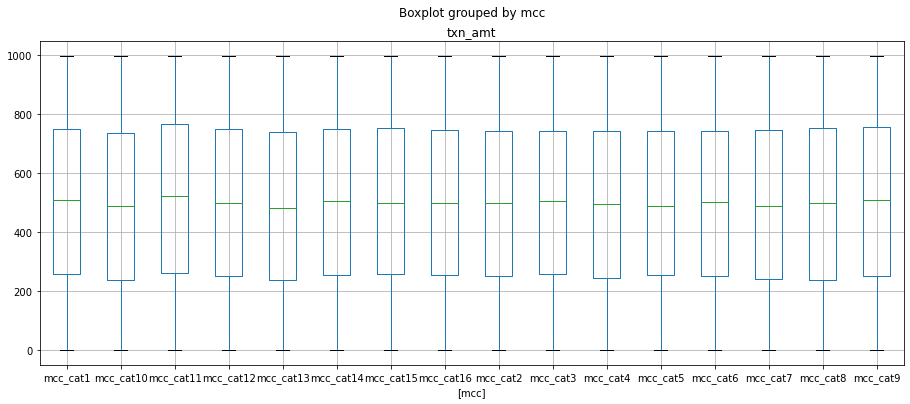

In [34]:
# further exploration on low transaction amount (let's say less than 1000) with "mcc" variable
card_trx_data.loc[card_trx_data.txn_amt < 1000, ['mcc', 'txn_amt']].boxplot(by='mcc', figsize=(15, 6))

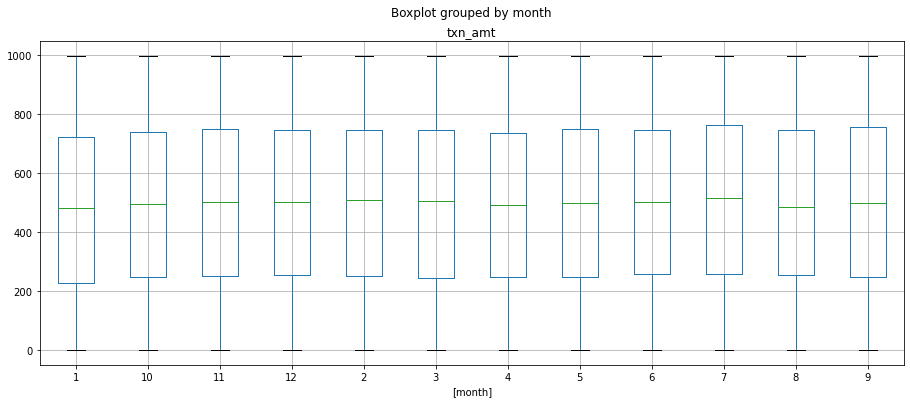

In [35]:
# further exploration on low transaction amount (let's say less than 1000) with transaction mth
D = card_trx_data.loc[card_trx_data.txn_amt < 1000, ['txn_dt', 'txn_amt']].copy()
D['month'] = D.txn_dt.dt.month
D.month = D.month.astype('str')
D.loc[:, ['txn_amt', 'month']].boxplot(by='month', figsize=(15, 6))

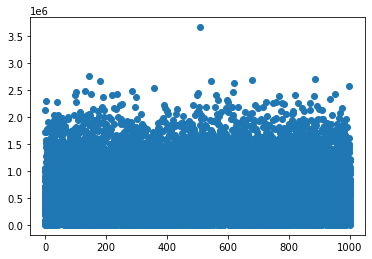

In [36]:
# further exploration on low transaction amount (let's say less than 1000) with credit limit amt
D = card_trx_data.loc[card_trx_data.txn_amt < 1000, ['card_no', 'txn_amt']].copy()
D = D.merge(card_info_data, left_on='card_no', right_on='card_no')
plt.scatter(D['txn_amt'], D['cr_lmt_amt'])

In [37]:
# We couldn't see any significant relationship between those low transaction amount and other information available. Therefore, 
# as we don't have any other information on appropriate transactional values, we gonna keep those low transactional values
# as it is,

### 3.1.5 Exploring aggregated income-outgoing transaction data

In [38]:
cust_incomeoutgoing_data.shape

(490599, 4)

In [39]:
cust_incomeoutgoing_data.isnull().sum()

user_id    0
mm         0
amt_in     0
amt_out    0
dtype: int64

In [40]:
cust_incomeoutgoing_data.dtypes

user_id      int64
mm           int64
amt_in     float64
amt_out    float64
dtype: object

In [41]:
cust_incomeoutgoing_data.mm.value_counts()

3     41274
10    41076
11    41046
6     41012
7     40901
5     40887
2     40839
12    40821
1     40803
8     40786
9     40777
4     40377
Name: mm, dtype: int64

In [42]:
cust_incomeoutgoing_data[['amt_in', 'amt_out']].describe()

,amt_in,amt_out
count,490599.000000,490599.000000
mean,29138.628566,31495.501874
std,35951.833744,36826.856701
min,0.000000,0.000000
25%,0.000000,0.000000
50%,16445.000000,19882.000000
75%,47011.000000,50507.000000
max,362315.000000,330059.000000


Findings from the exploration
* Data type of `user_id` and `mm` column is not quite appropriate, some correction is needed

In [43]:
cust_incomeoutgoing_data.user_id = cust_incomeoutgoing_data.user_id.astype('str')
cust_incomeoutgoing_data.mm = cust_incomeoutgoing_data.mm.astype('str')

### 3.1.6 Exploring aggregated saving account balance data

In [44]:
cust_savingbalance_data.shape

(633144, 3)

In [45]:
cust_savingbalance_data.isnull().sum()

user_id       0
mm            0
max_sa_bal    0
dtype: int64

In [46]:
cust_savingbalance_data.dtypes

user_id         int64
mm              int64
max_sa_bal    float64
dtype: object

In [47]:
cust_savingbalance_data.mm.value_counts()

12    52762
11    52762
10    52762
9     52762
8     52762
7     52762
6     52762
5     52762
4     52762
3     52762
2     52762
1     52762
Name: mm, dtype: int64

In [48]:
cust_savingbalance_data.max_sa_bal.describe()

count    6.331440e+05
mean     4.891968e+05
std      4.046495e+05
min      0.000000e+00
25%      1.750880e+05
50%      4.289285e+05
75%      7.124432e+05
max      3.648044e+06
Name: max_sa_bal, dtype: float64

Findings from the exploration
* Data type of `user_id` and `mm` column is not quite appropriate, some correction is needed

In [49]:
cust_savingbalance_data.user_id = cust_savingbalance_data.user_id.astype('str')
cust_savingbalance_data.mm = cust_savingbalance_data.mm.astype('str')

<a name='3.1'></a>
## 3.2 - Data Aggregation

* Aggregate `training_data` with `cust_demo_data` and developing some useful features

In [50]:
data = training_data.copy()
data = data.merge(cust_demo_data, left_on='user_id', right_on='user_id')
# developing "account_age" feature
data['account_age'] = 2017 - data.account_start_date.dt.year
data.drop(columns='account_start_date', inplace=True, errors='ignore')
# developing "age" feature
data['age'] = 2017 - data['birth_year']
data.drop(columns='birth_year', inplace = True, errors='ignore')

* Aggregate `training_data` with `card_info_data` and developing some useful features

In [51]:
# developing "no_card" and "total_cr_lmt_amt" feature
card_info_agg = card_info_data.groupby('user_id').agg({'cr_lmt_amt': 'sum', 'card_no': 'count'}).reset_index().rename(columns={'cr_lmt_amt': 'total_cr_lmt_amt', 'card_no':'no_card'})
data = data.merge(card_info_agg, left_on='user_id', right_on='user_id')

* Aggregate `training_data` with `card_trx_data` and developing some useful features

In [52]:
# developing "total_txn", "max_txn", and "count_txn" features (aggregate value for txn_amt)
aggregate_trx_data = card_trx_data.groupby('user_id')['txn_amt'].agg(['sum', 'max', 'count']).reset_index().rename(columns={'sum': 'total_txn', 'max': 'max_txn', 'count': 'count_txn'})
# developing "max_diff_txn_dt" and "mean_diff_txn_dt" features (time-diff usage features)
time_diff_data = card_trx_data.sort_values(by = ['user_id', 'txn_dt']).copy()
time_diff_data['diff'] = time_diff_data.groupby('user_id')['txn_dt'].diff().dt.days
time_diff_data = time_diff_data.groupby('user_id')['diff'].agg(['max', 'mean']).reset_index().rename(columns={'max': 'max_diff_txn_dt', 'mean': 'mean_diff_txn_dt'})
# developing "day_since_last_trx" feature
last_txn_data = card_trx_data.groupby('user_id')['txn_dt'].agg(['max']).reset_index().rename(columns={'max':'max_txn_dt'})
last_txn_data['day_since_last_txn'] = (pd.to_datetime('2018-01-01') - last_txn_data['max_txn_dt']).dt.days
last_txn_data = last_txn_data[['user_id', 'day_since_last_txn']]
# developing "max_credit_util", "mean_credit_util", "std_credit_util" features (credit utilization features)
credit_util_data = card_trx_data.copy()
credit_util_data['month'] = credit_util_data.txn_dt.dt.month
credit_util_data = credit_util_data[['user_id', 'card_no', 'month', 'txn_amt']].groupby(['user_id', 'card_no', 'month'])['txn_amt'].sum().reset_index().rename(columns={'txn_amt':'total_txn_amt'})
credit_util_data = credit_util_data.merge(card_info_data[['user_id', 'card_no', 'cr_lmt_amt']], left_on=['user_id', 'card_no'], right_on=['user_id', 'card_no'])
credit_util_data = credit_util_data.groupby(['user_id', 'month']).agg({'total_txn_amt':'sum', 'cr_lmt_amt':'sum'}).reset_index()
credit_util_data['credit_util'] = credit_util_data.apply(lambda x : min(x['total_txn_amt'], x['cr_lmt_amt']), axis = 1)/credit_util_data.cr_lmt_amt
credit_util_data = credit_util_data.groupby('user_id')['credit_util'].agg(['max', 'mean', 'std']).reset_index().rename(columns={'max':'max_credit_util', 'mean':'mean_credit_util', 'std':'std_credit_util'})
# developing "most_purchasing_category", "avg_purchasing_value" features (most spending category wrt count)
frequent_spending = card_trx_data.groupby(['user_id'])[['mcc']].agg(lambda x: pd.Series.mode(x)[0]).reset_index().rename(columns={'mcc': 'most_purchasing_category'})
frequent_spending = frequent_spending.merge(card_trx_data, left_on=['user_id', 'most_purchasing_category'], right_on=['user_id', 'mcc'])
frequent_spending = frequent_spending.groupby(['user_id', 'most_purchasing_category'])[['txn_amt']].mean().reset_index().rename(columns={'txn_amt': 'avg_perchasing_value'})
# developing "least_perchasing_category" feature (least spending category wrt count)
least_spending = card_trx_data.groupby(['user_id'])[['mcc']].agg(lambda x: x.value_counts().index[-1]).reset_index().rename(columns={'mcc': 'least_purchasing_category'})
# aggregating all data with training data
data = reduce(lambda left,right: pd.merge(left, right, on=['user_id'], how='left'), [data, aggregate_trx_data, time_diff_data, last_txn_data, credit_util_data, frequent_spending, least_spending])

* Aggregate `training_data` with `cust_savingbalance_data` and developing some useful features

In [53]:
# developing "max_sa_bal", "avg_sa_bal", and "std_sa_bal" features
sav_bal_agg = cust_savingbalance_data.groupby(['user_id'])['max_sa_bal'].agg(['max', 'mean', 'std']).reset_index().rename(columns={'max':'max_sa_bal', 'mean':'avg_sa_bal', 'std':'std_sa_bal'})
# developing "sa_bal_remain" feature (sa_bal within month 12)
sav_bal_remain = cust_savingbalance_data.loc[cust_savingbalance_data.mm == '12', ['user_id', 'max_sa_bal']].rename(columns={'max_sa_bal':'sa_bal_remain'})
data = reduce(lambda left, right: pd.merge(left, right, on=['user_id'], how='left'), [data, sav_bal_agg, sav_bal_remain])

* Aggregate `training_data` with `cust_incomeoutgoing_data` and developing some useful features

In [54]:
# developing "max_amt_in" and "max_amt_out" features
max_amt = cust_incomeoutgoing_data.groupby(['user_id']).agg({'amt_in':'max', 'amt_out':'max'}).reset_index().rename(columns={'amt_in':'max_amt_in', 'amt_out':'max_amt_out'})
# developing "total_amt_diff" features (total_amt_in - total_amt_out)
total_amt = cust_incomeoutgoing_data.groupby(['user_id']).agg({'amt_in':'sum', 'amt_out':'sum'}).reset_index().rename(columns={'amt_in':'total_amt_in', 'amt_out':'total_amt_out'})
total_amt['total_amt_diff'] = total_amt.total_amt_in - total_amt.total_amt_out
total_amt = total_amt[['user_id', 'total_amt_diff']]
data = reduce(lambda left, right: pd.merge(left, right, on=['user_id'], how='left'), [data, max_amt, total_amt])

<a name='3.3'></a>
## 3.3 Exploratory Data Analysis (EDA)

Analyze aggregated transactional data from previous step to summarize main characteristic and assumptions from data, including data distribution, outliers, relationship between each variable, and hidden patterns using Statistical and Visualization tools.

In [55]:
data.set_index('user_id', inplace=True)

<a name='3.3.1'></a>
### 3.3.1 Univariate Analysis

variable name : label
number of rows : 345
unique value counts : 2
unique values : ['1', '0']
null value counts : 0


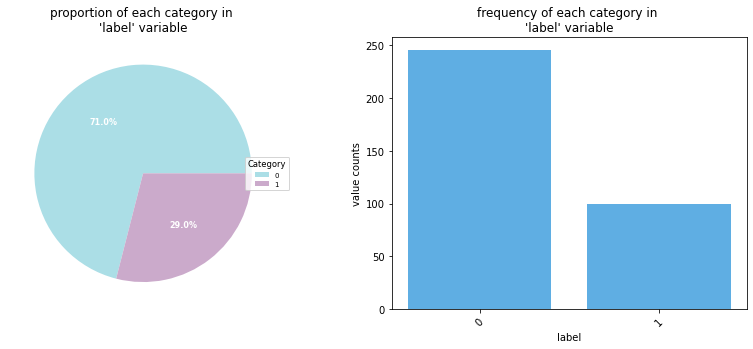

variable name : gender
number of rows : 345
unique value counts : 2
unique values : ['M', 'F']
null value counts : 0


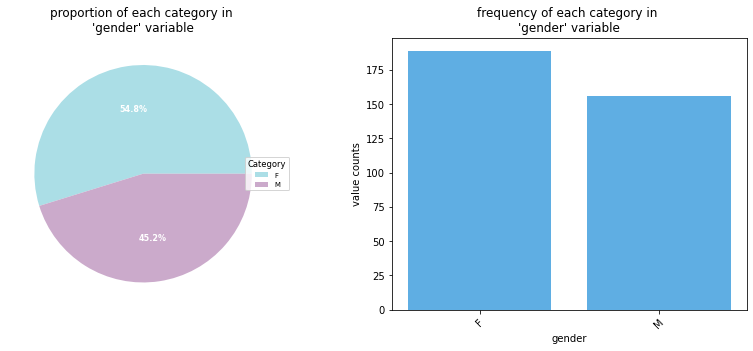

variable name : marital_status
number of rows : 345
unique value counts : 4
unique values : ['1', '3', '2', nan]
null value counts : 81


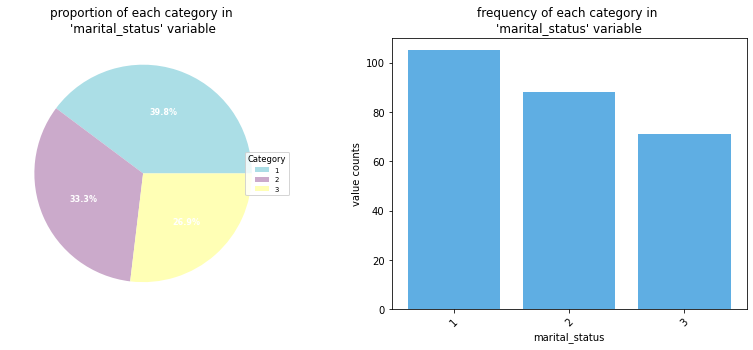

variable name : family_income_segment_code
number of rows : 345
unique value counts : 8
unique values : ['02', '01', '03', '04', '05', nan, '07', '06']
null value counts : 48


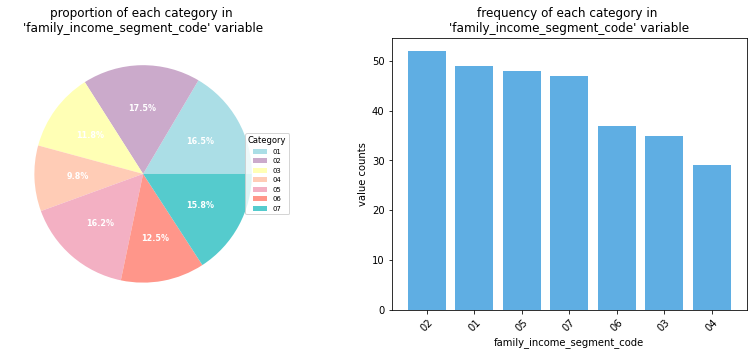

variable name : individual_income_segment_code
number of rows : 345
unique value counts : 16
unique values : ['06', '09', '04', '14', '15', '08', '02', '10', '12', nan, '11', '05', '01', '03', '13', '07']
null value counts : 21


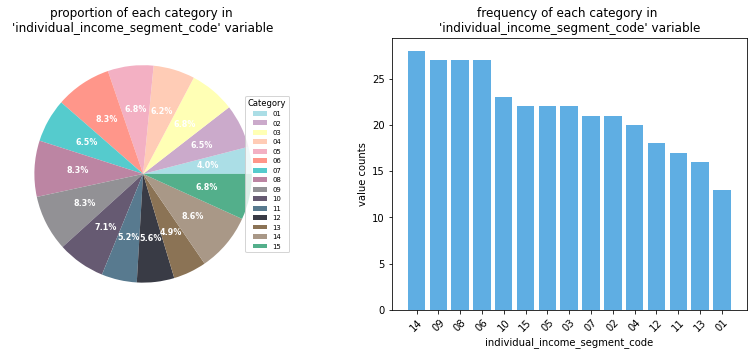

variable name : account_age
number of rows : 345
null value counts : 0
mean value : 45.47
std value : 6.57
min value : 25.00
25th percentile value : 41.00
50th percentile value : 45.00
75th percentile value : 50.00
max value : 64.00


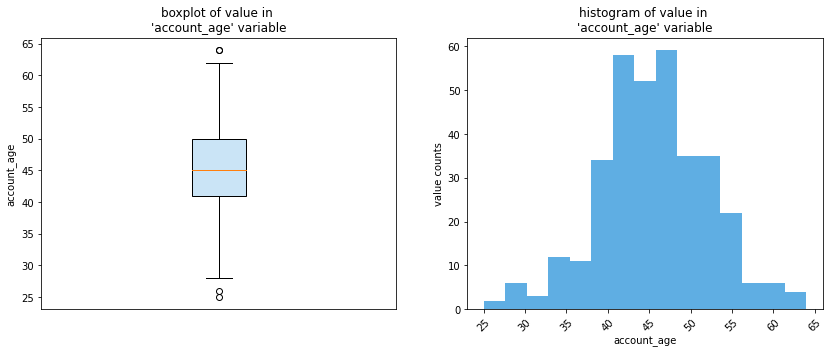

variable name : age
number of rows : 345
null value counts : 0
mean value : 68.97
std value : 9.29
min value : 38.00
25th percentile value : 63.00
50th percentile value : 69.00
75th percentile value : 74.00
max value : 104.00


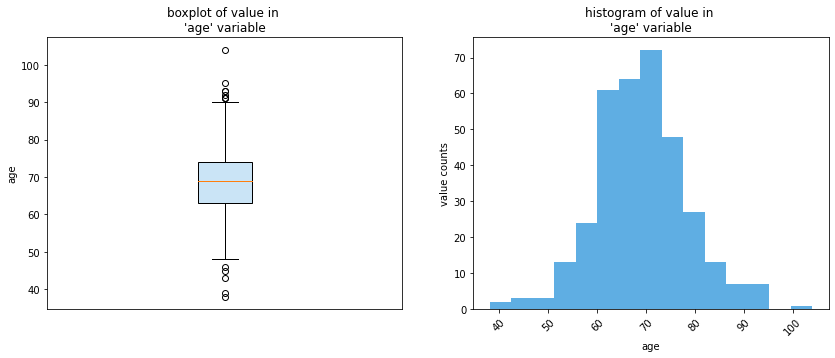

variable name : total_cr_lmt_amt
number of rows : 345
null value counts : 0
mean value : 567753.62
std value : 417476.25
min value : 4000.00
25th percentile value : 267000.00
50th percentile value : 483000.00
75th percentile value : 767000.00
max value : 2364000.00


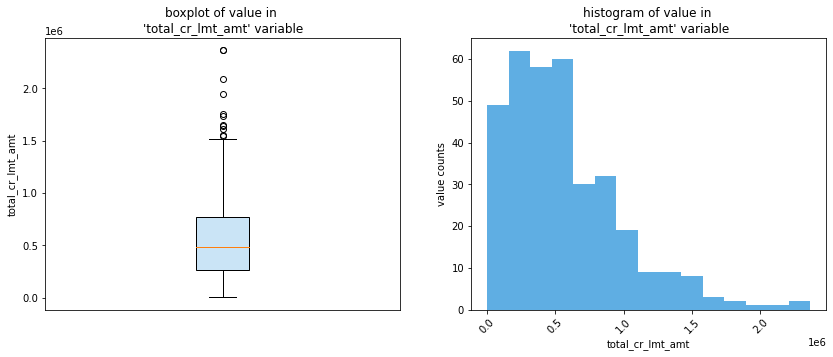

variable name : no_card
number of rows : 345
null value counts : 0
mean value : 1.12
std value : 0.33
min value : 1.00
25th percentile value : 1.00
50th percentile value : 1.00
75th percentile value : 1.00
max value : 3.00


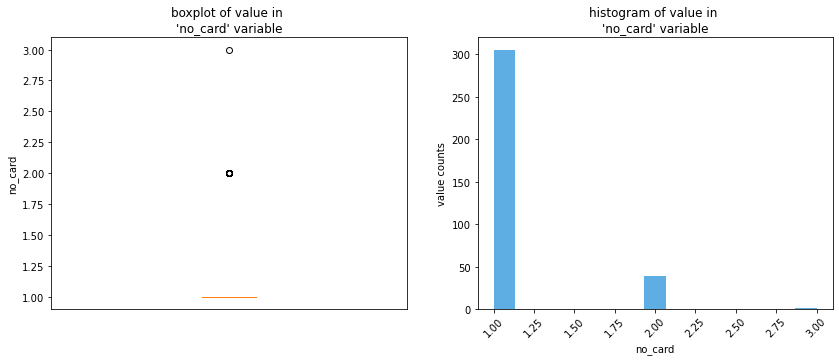

variable name : total_txn
number of rows : 345
null value counts : 0
mean value : 2666534.63
std value : 1137846.83
min value : 1205977.00
25th percentile value : 1867850.00
50th percentile value : 2290762.00
75th percentile value : 3225270.00
max value : 7791954.00


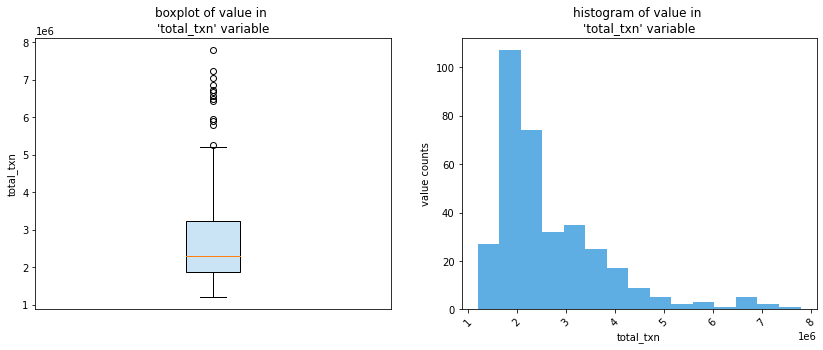

variable name : max_txn
number of rows : 345
null value counts : 0
mean value : 145257.44
std value : 44717.15
min value : 80096.00
25th percentile value : 112633.00
50th percentile value : 129678.00
75th percentile value : 172960.00
max value : 305718.00


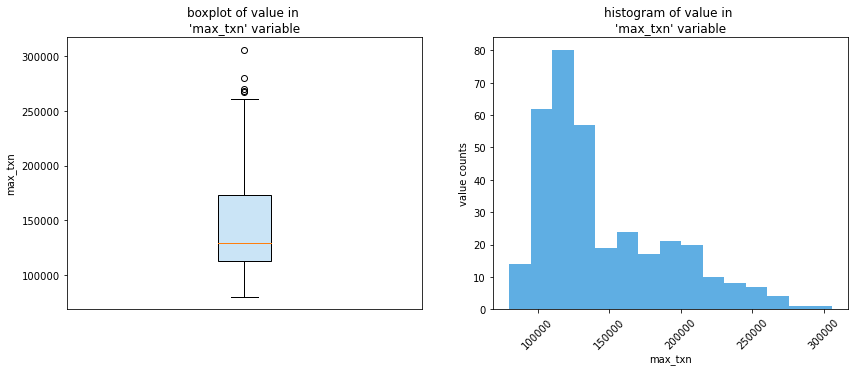

variable name : count_txn
number of rows : 345
null value counts : 0
mean value : 59.77
std value : 18.60
min value : 36.00
25th percentile value : 50.00
50th percentile value : 54.00
75th percentile value : 61.00
max value : 146.00


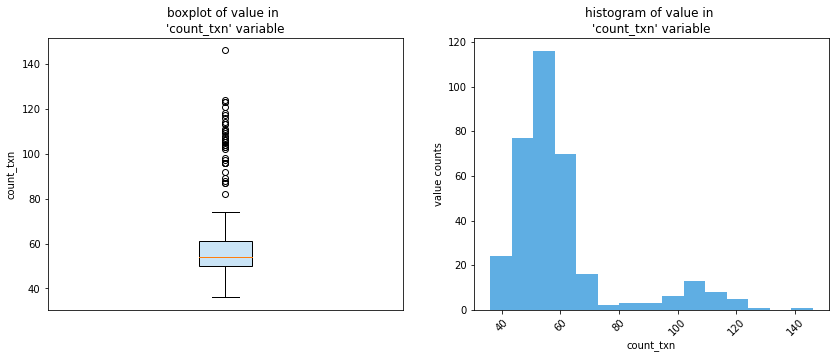

variable name : max_diff_txn_dt
number of rows : 345
null value counts : 0
mean value : 26.92
std value : 8.91
min value : 10.00
25th percentile value : 22.00
50th percentile value : 26.00
75th percentile value : 31.00
max value : 70.00


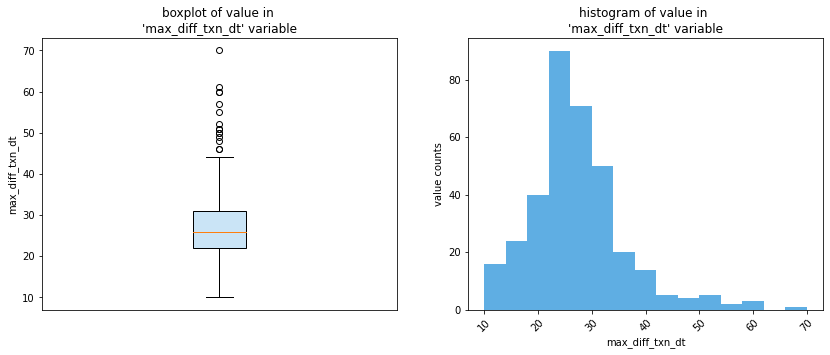

variable name : mean_diff_txn_dt
number of rows : 345
null value counts : 0
mean value : 5.98
std value : 1.31
min value : 2.33
25th percentile value : 5.49
50th percentile value : 6.15
75th percentile value : 6.66
max value : 9.31


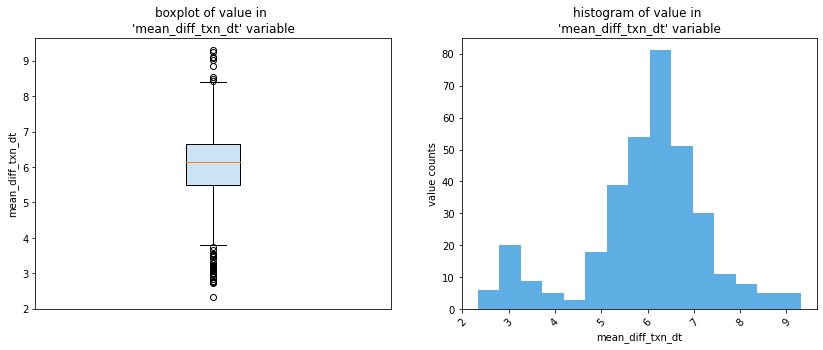

variable name : day_since_last_txn
number of rows : 345
null value counts : 0
mean value : 6.30
std value : 6.19
min value : 1.00
25th percentile value : 2.00
50th percentile value : 4.00
75th percentile value : 8.00
max value : 33.00


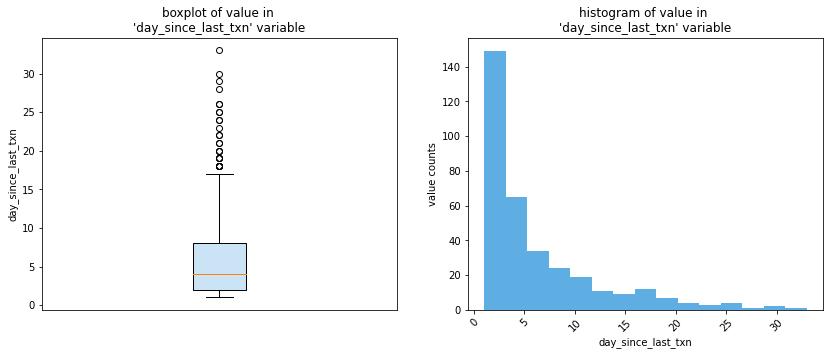

variable name : max_credit_util
number of rows : 345
null value counts : 0
mean value : 0.80
std value : 0.24
min value : 0.20
25th percentile value : 0.59
50th percentile value : 0.98
75th percentile value : 1.00
max value : 1.00


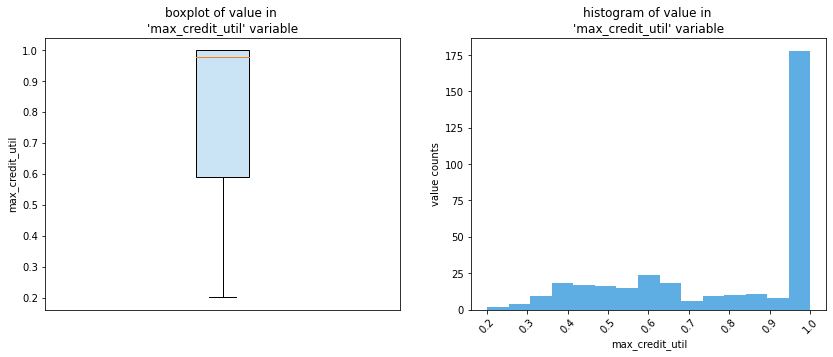

variable name : mean_credit_util
number of rows : 345
null value counts : 0
mean value : 0.50
std value : 0.25
min value : 0.10
25th percentile value : 0.28
50th percentile value : 0.45
75th percentile value : 0.70
max value : 1.00


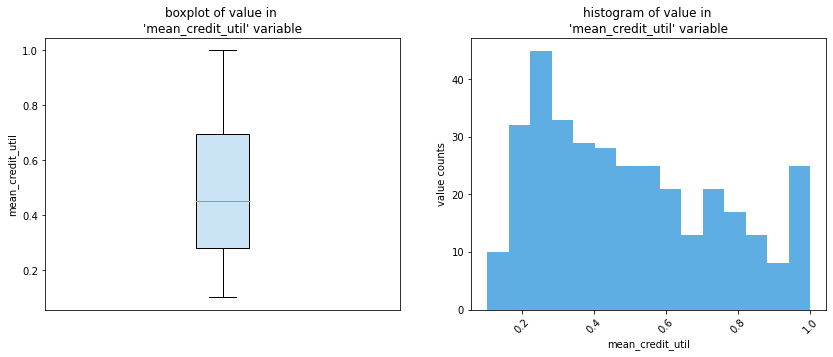

variable name : std_credit_util
number of rows : 345
null value counts : 0
mean value : 0.21
std value : 0.09
min value : 0.00
25th percentile value : 0.14
50th percentile value : 0.22
75th percentile value : 0.29
max value : 0.42


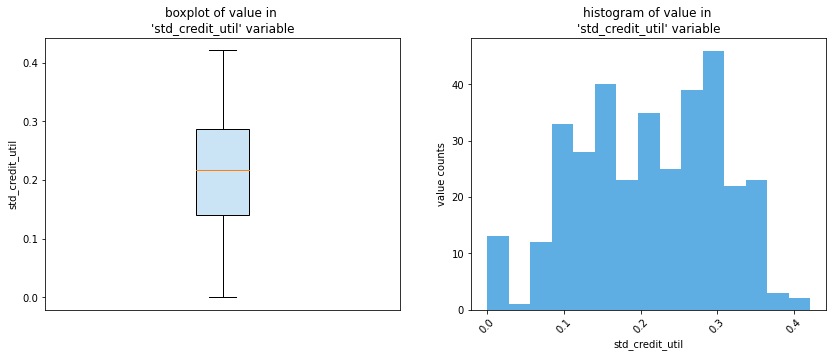

variable name : most_purchasing_category
number of rows : 345
unique value counts : 16
unique values : ['mcc_cat10', 'mcc_cat9', 'mcc_cat5', 'mcc_cat12', 'mcc_cat11', 'mcc_cat1', 'mcc_cat2', 'mcc_cat7', 'mcc_cat13', 'mcc_cat16', 'mcc_cat4', 'mcc_cat3', 'mcc_cat6', 'mcc_cat8', 'mcc_cat14', 'mcc_cat15']
null value counts : 0


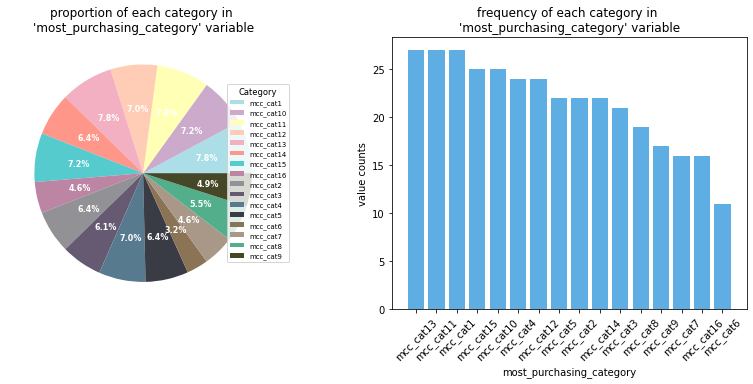

variable name : avg_perchasing_value
number of rows : 345
null value counts : 0
mean value : 44314.82
std value : 17054.27
min value : 12269.40
25th percentile value : 31496.00
50th percentile value : 41767.88
75th percentile value : 54842.00
max value : 101770.38


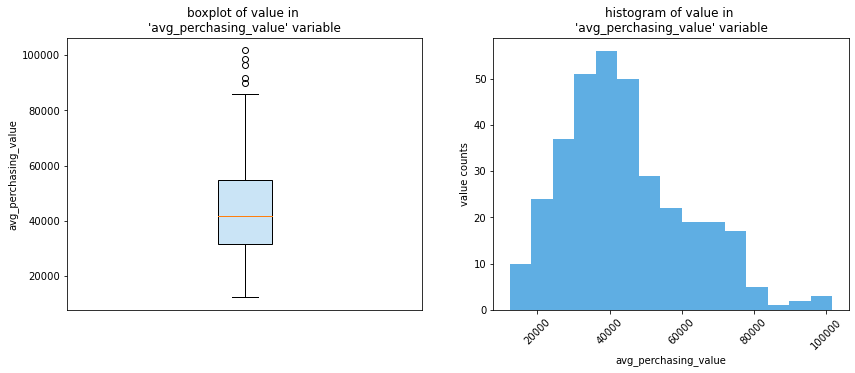

variable name : least_purchasing_category
number of rows : 345
unique value counts : 16
unique values : ['mcc_cat4', 'mcc_cat3', 'mcc_cat2', 'mcc_cat8', 'mcc_cat7', 'mcc_cat12', 'mcc_cat14', 'mcc_cat9', 'mcc_cat11', 'mcc_cat6', 'mcc_cat10', 'mcc_cat5', 'mcc_cat16', 'mcc_cat13', 'mcc_cat1', 'mcc_cat15']
null value counts : 0


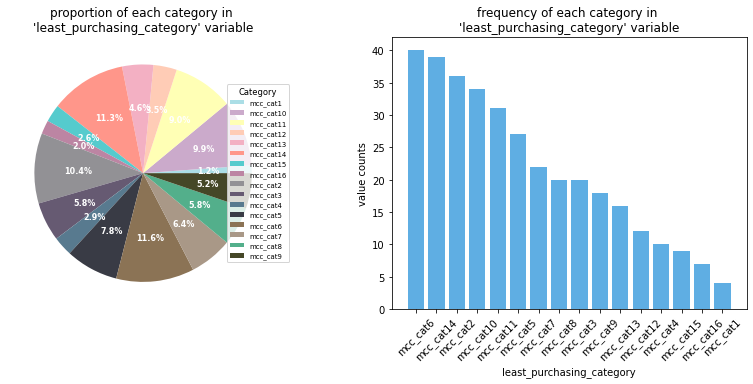

variable name : max_sa_bal
number of rows : 345
null value counts : 0
mean value : 1175011.73
std value : 402810.56
min value : 481942.00
25th percentile value : 873128.00
50th percentile value : 1076014.00
75th percentile value : 1418512.00
max value : 2610468.00


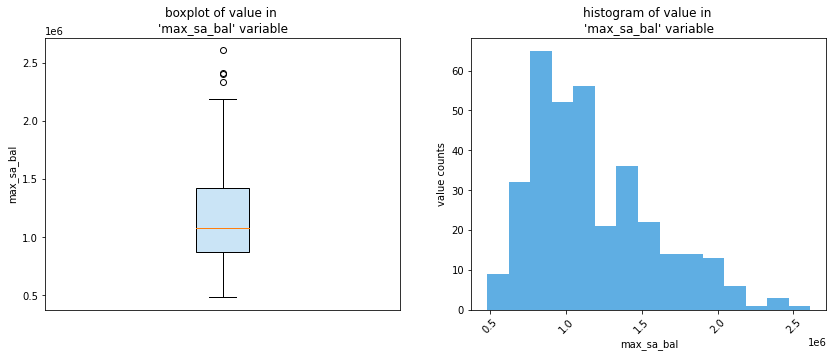

variable name : avg_sa_bal
number of rows : 345
null value counts : 0
mean value : 497939.61
std value : 169600.86
min value : 192345.42
25th percentile value : 379104.17
50th percentile value : 457668.08
75th percentile value : 580497.33
max value : 1080514.92


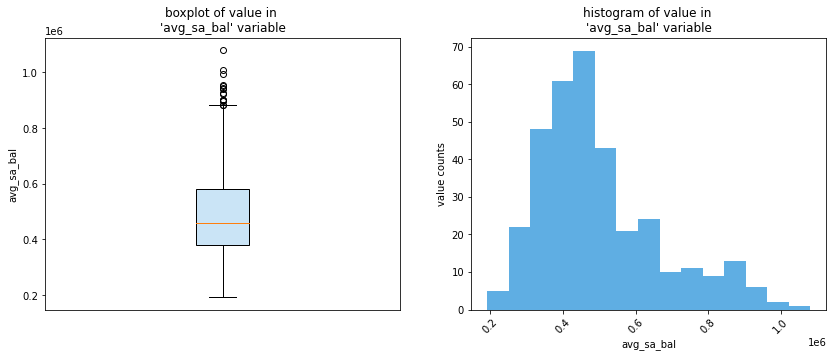

variable name : std_sa_bal
number of rows : 345
null value counts : 0
mean value : 368217.73
std value : 125924.67
min value : 144215.50
25th percentile value : 273545.64
50th percentile value : 333467.47
75th percentile value : 446291.14
max value : 791549.28


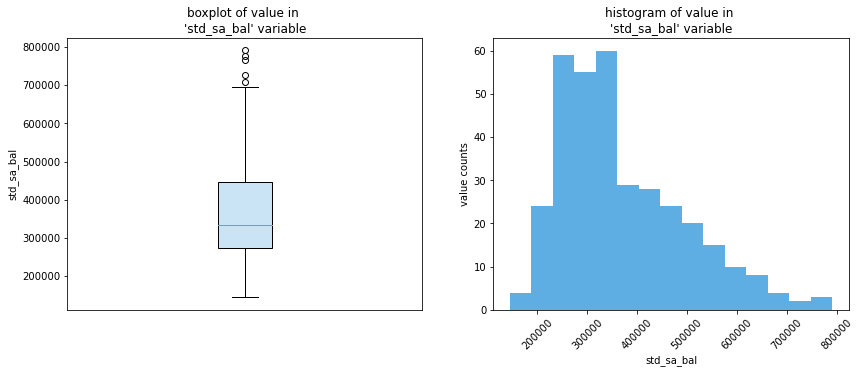

variable name : sa_bal_remain
number of rows : 345
null value counts : 0
mean value : 504579.91
std value : 413395.10
min value : 0.00
25th percentile value : 204637.00
50th percentile value : 442674.00
75th percentile value : 691361.00
max value : 2128782.00


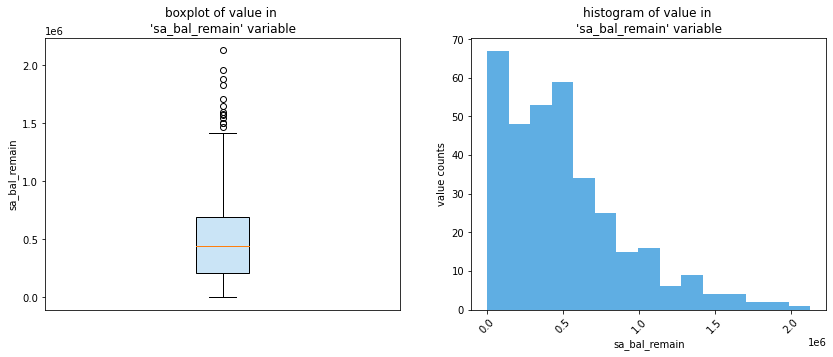

variable name : max_amt_in
number of rows : 345
null value counts : 0
mean value : 91897.34
std value : 39295.74
min value : 17559.00
25th percentile value : 64917.00
50th percentile value : 85183.00
75th percentile value : 112547.00
max value : 250284.00


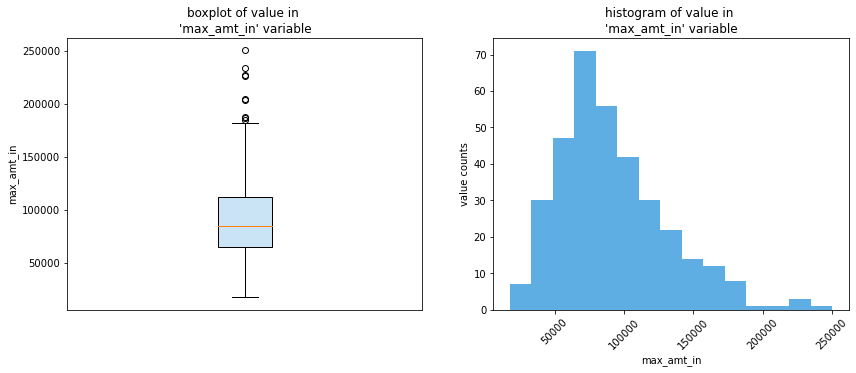

variable name : max_amt_out
number of rows : 345
null value counts : 0
mean value : 95731.88
std value : 39358.87
min value : 23557.00
25th percentile value : 64080.00
50th percentile value : 90363.00
75th percentile value : 117641.00
max value : 243239.00


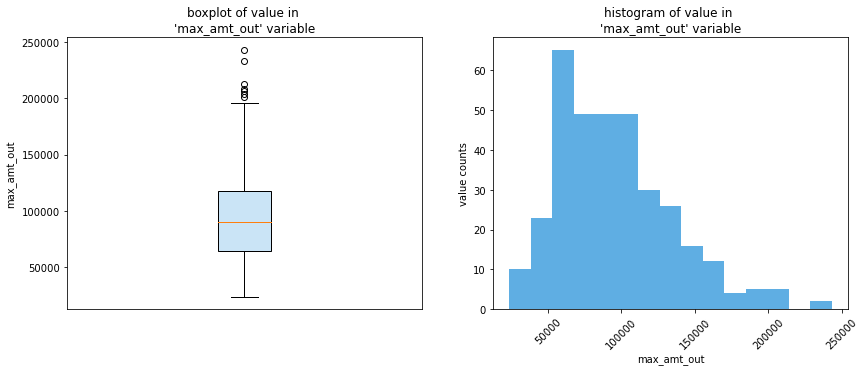

variable name : total_amt_diff
number of rows : 345
null value counts : 0
mean value : -22788.99
std value : 183088.43
min value : -546066.00
25th percentile value : -138518.00
50th percentile value : -17011.00
75th percentile value : 86121.00
max value : 572279.00


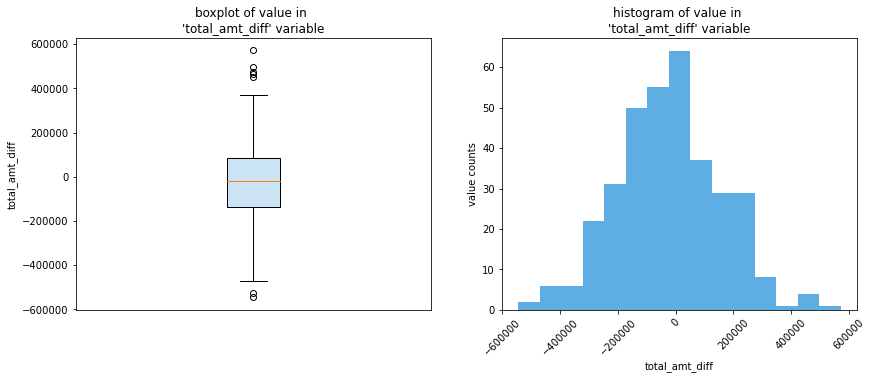

In [56]:
for col in data.columns:
    if data[col].dtypes == 'O':
        data_shape = data[col].shape[0]
        unique_value_counts = len(data[col].unique())
        unique_values = data[col].unique().tolist()
        null_value_counts = data[col].isnull().sum()
        print("===========================================================================================")
        print("variable name : %s" % col)
        print("===========================================================================================")
        print("number of rows : %s" % data_shape)
        print("unique value counts : %d" % unique_value_counts)
        print("unique values : %s" %  str(unique_values))
        print("null value counts : %d" % null_value_counts)
        # visualization
        fig, axs = plt.subplots(1, 2, figsize = (14,5))
        # pie chart - show the proportion of each category in variable
        counts = data[[col]].groupby([col]).size()
        count_values = counts.values.tolist()
        category = counts.index.values.tolist()
        colors = ['#ABDEE6','#CBAACB','#FFFFB5','#FFCCB6','#F3B0C3',\
                  '#FF968A','#55CBCD','#BC85A3','#929195','#665A72',\
                  '#587A8F','#393B45','#8B7355','#A99887','#53AF8B',\
                  '#454727','#F3B54A','#B9A66C','#008080','#063336']
        def func(pct, allvals):
            absolute = int(pct/100. * np.sum(allvals))
            return "{:.1f}%".format(pct, absolute)
        wedges, texts, autotexts = axs[0].pie(count_values, 
                                              autopct=lambda pct: func(pct, count_values), 
                                              textprops=dict(color="w"),
                                              colors=colors[:len(category)])
        axs[0].legend(wedges, category, title="Category", loc="center right",\
                      bbox_to_anchor=(1, 0, 0.05, 1), fontsize='x-small', title_fontsize='small')
        plt.setp(autotexts, size=8, weight="bold")
        axs[0].set_title("proportion of each category in \n'%s' variable" % col)
        # bar chart - show the frequency of each category in variable
        counts = counts.sort_values(ascending = False)
        axs[1].bar(counts.index, counts.values, color = '#5FAEE3')
        axs[1].set_title("frequency of each category in \n'%s' variable" % col)
        axs[1].set_xlabel(col)
        axs[1].set_ylabel("value counts")
        axs[1].tick_params(axis = 'x', labelrotation=45)
        plt.show()
        fig.clf()
    else:
        describe_variable = data[col].describe()
        data_shape, mean_value, std_value, min_value, per_25th_value, per_50th_value, per_75th_value, max_value = (int(describe_variable.loc['count']), describe_variable.loc['mean'], describe_variable.loc['std'], describe_variable.loc['min'], describe_variable.loc['25%'], describe_variable.loc['50%'], describe_variable.loc['75%'], describe_variable.loc['max'])
        null_value_counts = data[col].isnull().sum()
        print("===========================================================================================")
        print("variable name : %s" % col)
        print("===========================================================================================")
        print("number of rows : %d" % data_shape)
        print("null value counts : %d" % null_value_counts)
        print("mean value : %.2f" % mean_value)
        print("std value : %.2f" % std_value)
        print("min value : %.2f" % min_value)
        print("25th percentile value : %.2f" % per_25th_value)
        print("50th percentile value : %.2f" % per_50th_value)
        print("75th percentile value : %.2f" % per_75th_value)
        print("max value : %.2f" % max_value)
        # visualization
        fig, axs = plt.subplots(1, 2, figsize = (14,5))
        # box plot - see the outlier
        bp = axs[0].boxplot(data[col].dropna().values, patch_artist = True)
        for box in bp['boxes']:
            box.set(color='black')
            box.set(facecolor='#CAE4F6')
        axs[0].set_ylabel(col)
        axs[0].set_xticks([])
        axs[0].set_title("boxplot of value in \n'%s' variable" % col)
        # histogram - see the distribution 
        axs[1].hist(data[col].values, bins = 15, color = '#5FAEE3')
        axs[1].set_title("histogram of value in \n'%s' variable" % col)
        axs[1].set_xlabel(col)
        axs[1].set_ylabel("value counts")
        axs[1].tick_params(axis='x', labelrotation=45)
        plt.show()
        fig.clf()

Insight found from the Univariate Analysis
* Each category in `label` column are not uniform distributed
* `marital_status`, `family_income_segment_code`, `invididual_income_segment_code` variable contains NULL values
* `total_cr_lmt_amt` variable contains anomalies (focus on min value), which might indicates that credit limit amount data are not correctly collected
* `no_card` variable is non-numeric, may be treated as category
* `max_credit_util` mostly contains 1, may be discarded

In [57]:
# fill null
data.loc[:, ['marital_status', 'family_income_segment_code', 'individual_income_segment_code']] = data.loc[:, ['marital_status', 'family_income_segment_code', 'individual_income_segment_code']].fillna(value='Unknown')
# convert no_card as category
data.no_card = data.no_card.astype('str')
# discard max_credit_util column
del data['max_credit_util']

<a name='3.3.2'></a>
### 3.3.2 Bivariate Analysis

* Check relationship between each pair of numeric variables using Correlation Heatmap

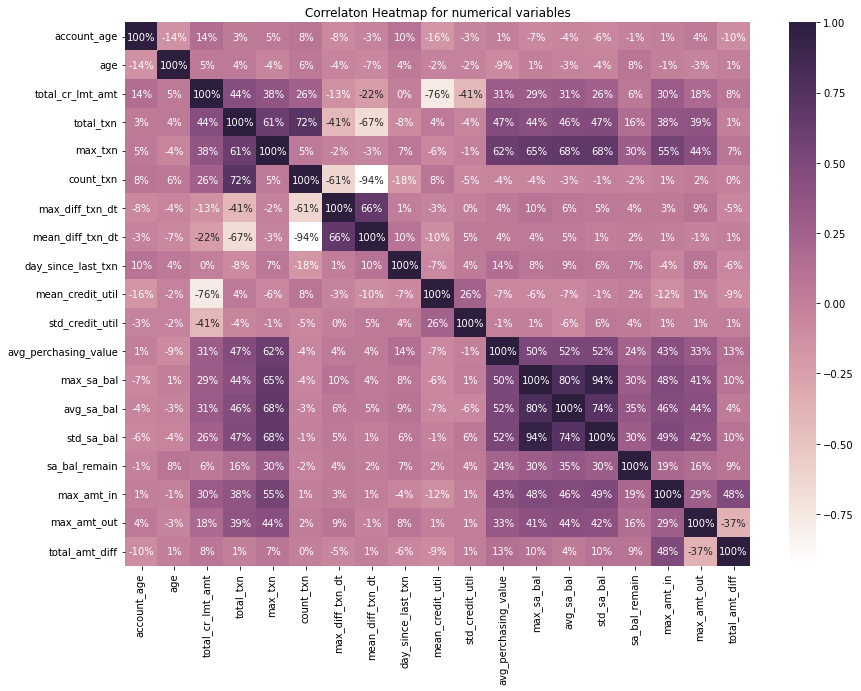

In [58]:
numeric_columns = data.select_dtypes(include='number').columns

plt.figure(figsize=(14, 10))
cmap = sns.cubehelix_palette(light=1, as_cmap=True) # color map
sns.heatmap(data[numeric_columns].corr(),
            fmt='.0%',
            annot=True,
            cmap=cmap)
plt.title("Correlaton Heatmap for numerical variables")
plt.show()

Insight found from the Univariate Analysis
* `count_txn` variable is highly correlated with `mean_diff_txn_dt`
* `max_sa_bal` variable is highly correlated with `avg_sa_bal` and `std_sa_bal`

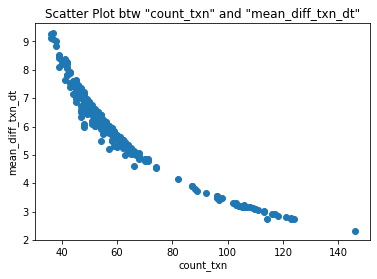

In [59]:
# scatter plot btw count_txn and mean_diff_txn_dt
plt.scatter(data['count_txn'], data['mean_diff_txn_dt'])
plt.xlabel('count_txn')
plt.ylabel('mean_diff_txn_dt')
plt.title('Scatter Plot btw "count_txn" and "mean_diff_txn_dt"')
plt.show()

Remove `mean_diff_txn_dt` variable

In [60]:
del data['mean_diff_txn_dt']

Text(0.5, 1.08, 'Pairplot btw "max_sa_bal", "avg_sa_bal", and "std_sa_bal"')

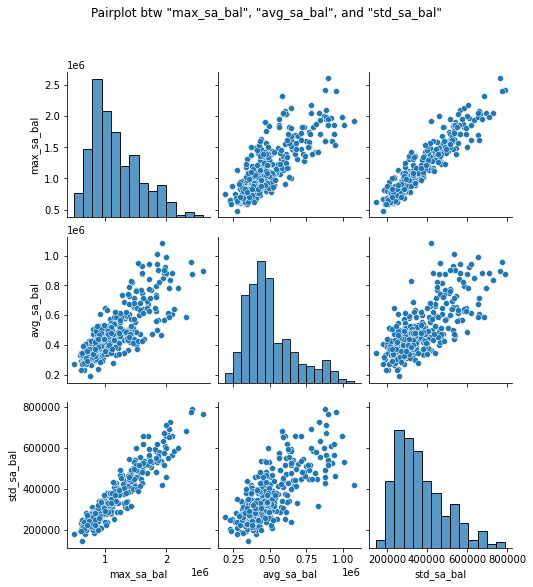

In [61]:
# pair plot btw max_sa_bal, avg_sa_bal, and std_sa_bal
rel = sns.pairplot(data[['max_sa_bal', 'avg_sa_bal', 'std_sa_bal']])
rel.fig.suptitle('Pairplot btw "max_sa_bal", "avg_sa_bal", and "std_sa_bal"', y=1.08)

Remove `std_sa_bal` variable

In [62]:
del data['std_sa_bal']

* Check relationship between each pair of categorical variables using Cramer V Correlation Heatmap

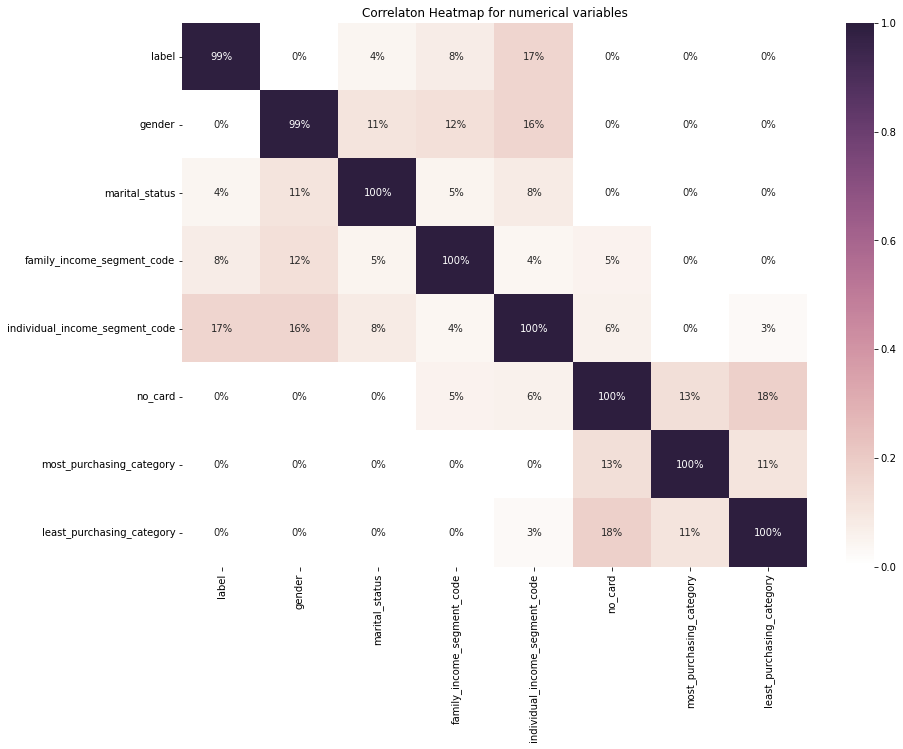

In [63]:
# ref : https://www.dezyre.com/recipes/drop-out-highly-correlated-features-in-python
# ref 2 : https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
def cramers_v(x,y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = np.max([0, phi2-((k-1)*(r-1))/(n-1)]).astype(float)
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/np.min([kcorr-1,rcorr-1]))

def create_categorical_corrmatrix(data, columns):
    l_matrix = []
    l_row = []
    for i,j in itertools.product(columns, columns):
        if len(l_row) == len(columns):
            l_matrix.append(l_row)
            l_row = []
        l_row.append(cramers_v(data[i],data[j]))
    l_matrix.append(l_row)
    return pd.DataFrame(l_matrix, index=columns, columns=columns)

categorical_columns = data.select_dtypes(include='object').columns

plt.figure(figsize=(14, 10))
cmap = sns.cubehelix_palette(light=1, as_cmap=True) # color map
sns.heatmap(create_categorical_corrmatrix(data, categorical_columns),
            fmt='.0%',
            annot=True,
            cmap=cmap)
plt.title("Correlaton Heatmap for numerical variables")
plt.show()

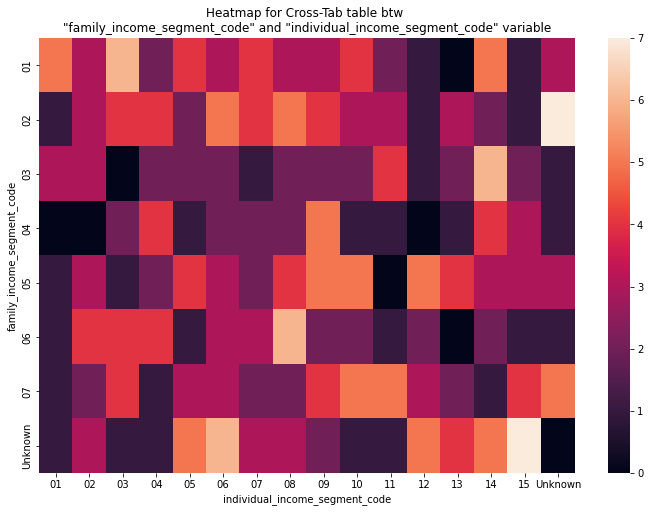

In [64]:
# explore more btw categorical variable pair
var1 = 'family_income_segment_code'
var2 = 'individual_income_segment_code'
plt.figure(figsize=(12, 8))
sns.heatmap(pd.crosstab(data[var1], data[var2])).set_title('Heatmap for Cross-Tab table btw \n"%s" and "%s" variable' % (var1, var2))
plt.show()

* Check relationship between each numeric variable and target variable using visualizations

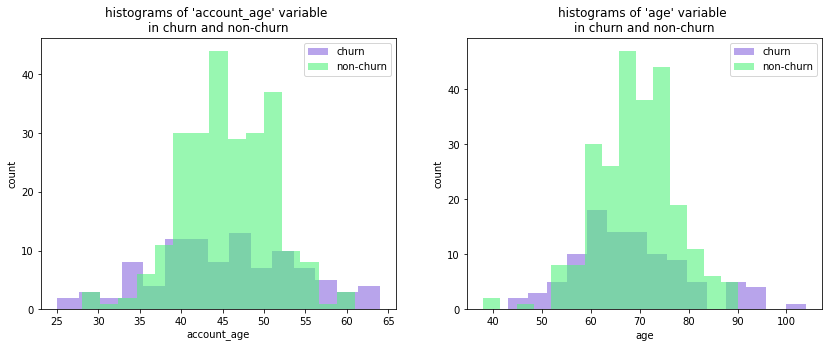

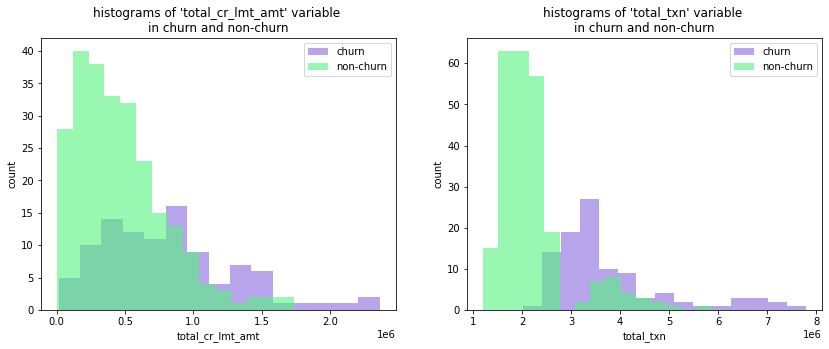

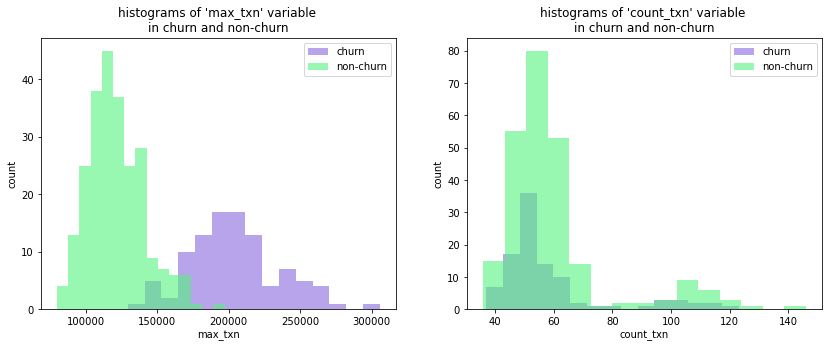

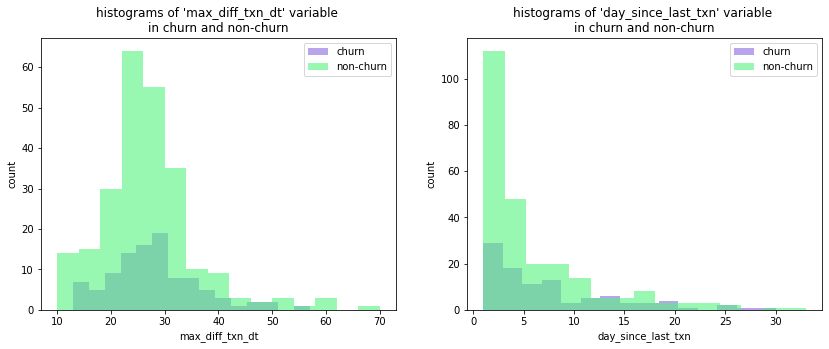

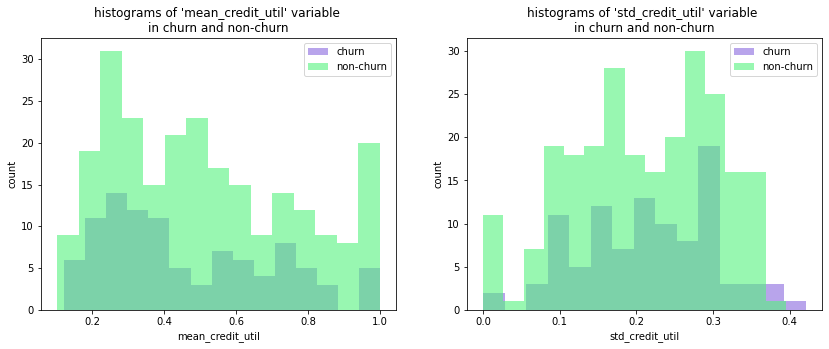

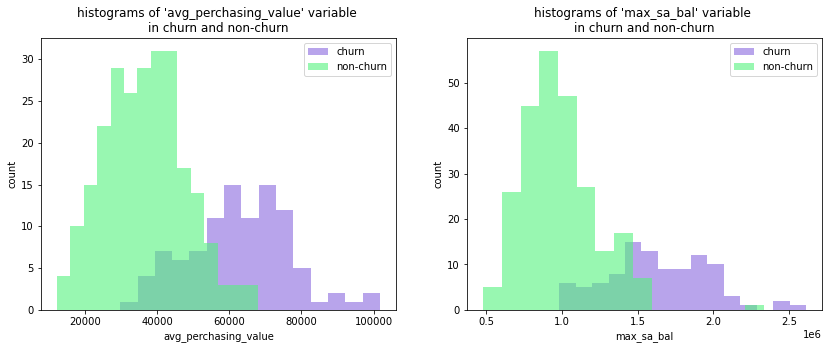

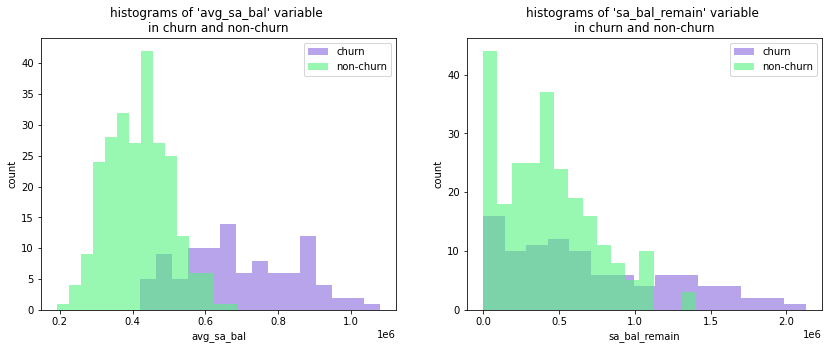

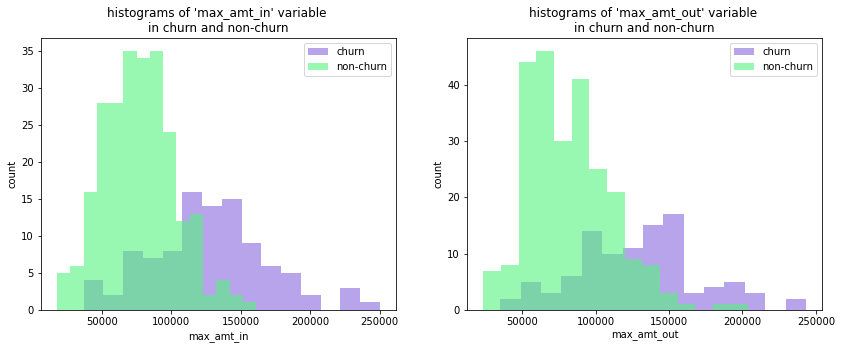

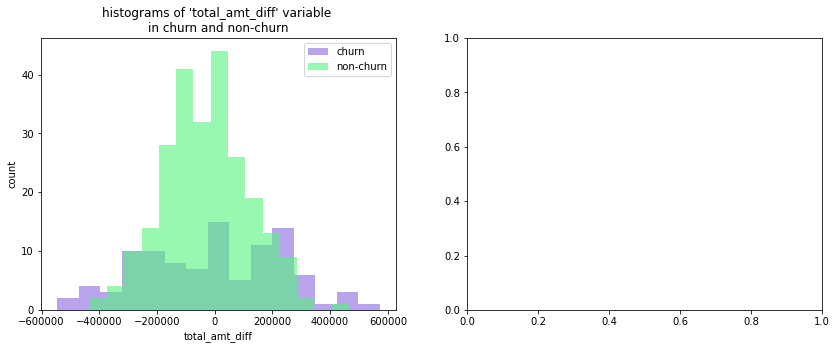

In [65]:
numeric_columns = data.select_dtypes(include='number').columns

for i in range(math.ceil(len(numeric_columns)/2)):
    try:
        fig, axs = plt.subplots(1, 2, figsize = (14,5))
        axs[0].hist(data.loc[data.label == '1', numeric_columns[2*i]], bins=15, color='#8A68DE', alpha=0.6, label='churn')
        axs[0].hist(data.loc[data.label == '0', numeric_columns[2*i]], bins=15, color='#54F27D', alpha=0.6, label='non-churn')
        axs[0].set_title("histograms of '%s' variable \nin churn and non-churn" % numeric_columns[2*i])
        axs[0].set_xlabel(numeric_columns[2*i])
        axs[0].set_ylabel('count')
        axs[0].legend(loc='upper right')
        axs[1].hist(data.loc[data.label == '1', numeric_columns[2*i+1]], bins=15, color='#8A68DE', alpha=0.6, label='churn')
        axs[1].hist(data.loc[data.label == '0', numeric_columns[2*i+1]], bins=15, color='#54F27D', alpha=0.6, label='non-churn')
        axs[1].set_title("histograms of '%s' variable \nin churn and non-churn" % numeric_columns[2*i+1])
        axs[1].set_xlabel(numeric_columns[2*i+1])
        axs[1].set_ylabel('count')
        axs[1].legend(loc='upper right')
    except IndexError:
        pass
    plt.show()
    fig.clf()

Insight found from the Analysis
* `max_txn` variable has high-predicitive power
* `avg_perchasing_value` variable has high-predicitive power
* `max_sa_bal` variable has high-predicitive power
* `avg_sa_bal` variable has high-predicitive power
* `max_amt_in` variable has high-predicitive power

* Check relationship between categorical variable and target variable using visualizations

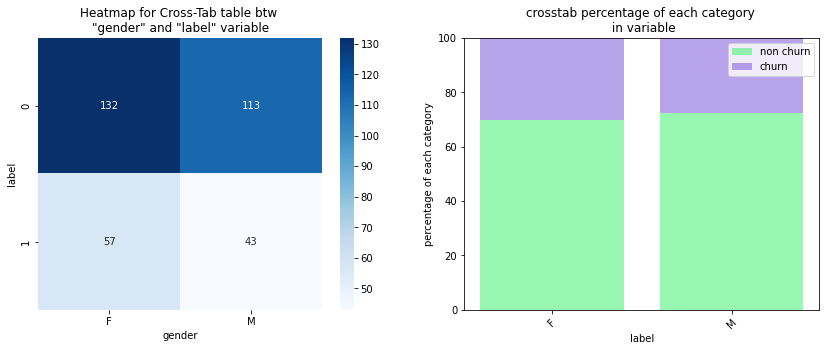

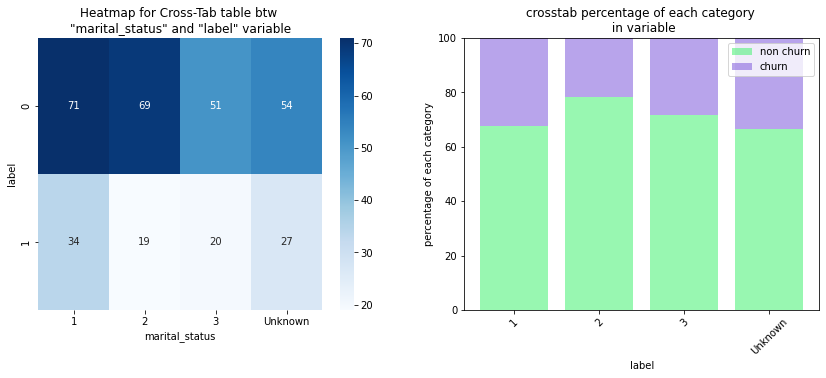

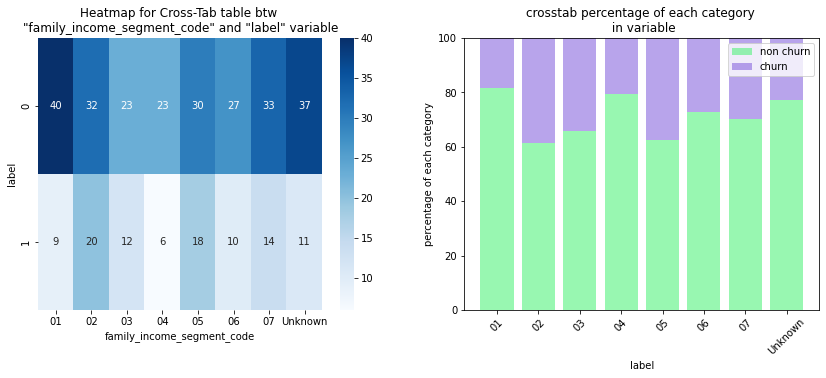

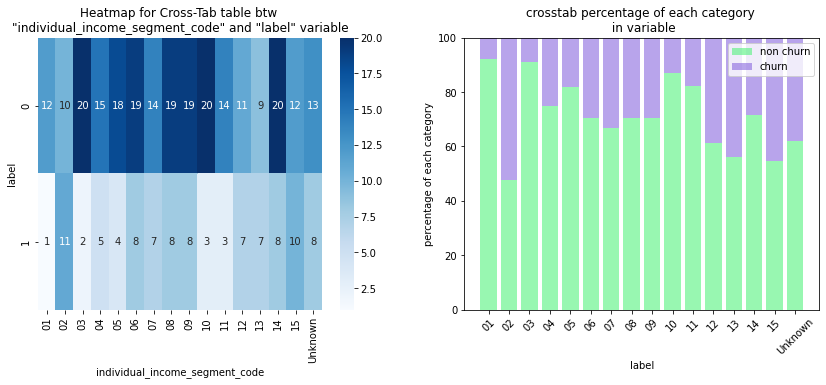

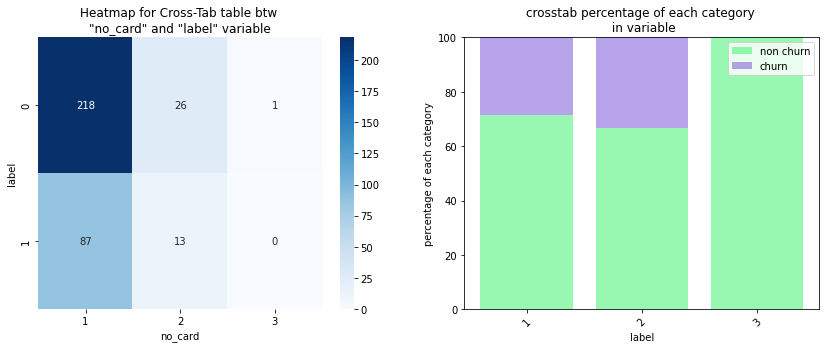

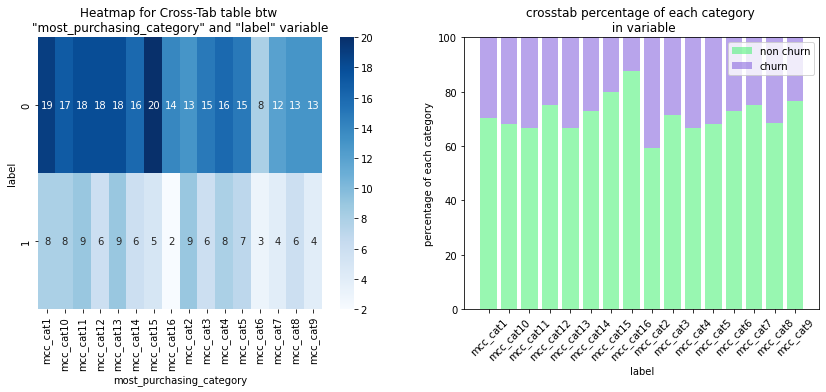

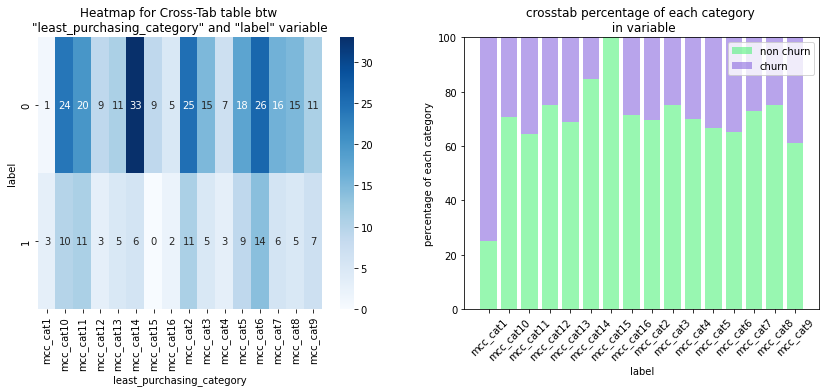

In [66]:
categorical_columns = data.select_dtypes(include='object').columns.values.tolist()
categorical_columns.remove('label')

for col in categorical_columns:
    fig, axs = plt.subplots(1, 2, figsize = (14,5))
    sns.heatmap(pd.crosstab(data['label'], data[col]), annot=True, fmt='g', cmap='Blues', ax=axs[0]).set_title('Heatmap for Cross-Tab table btw \n"%s" and "%s" variable' % (col, 'label'))
    # stack bar chart - show the relationship btw category variable and label
    percent_each_class = pd.crosstab(data["label"], data[col]).apply(lambda x : 100*x/x.sum(),axis = 0)
    stack = [0]*percent_each_class.shape[1]
    color_list = ['#54F27D','#8A68DE'] 
    xticks = percent_each_class.columns.values.tolist()
    for k, c in enumerate(percent_each_class.index.values.tolist()):
        axs[1].bar(x = xticks, height = percent_each_class.loc[c].values.tolist(), \
                   label = "non churn" if c == '0' else "churn", bottom = stack, color = color_list[k], alpha = 0.6)
        stack = [m + n for m,n in zip(stack,percent_each_class.loc[c].values.tolist())]
    axs[1].set_xticklabels(xticks, rotation=45, fontsize=10)
    axs[1].set_ylim(0,100)
    axs[1].set_ylabel("percentage of each category")
    axs[1].set_xlabel("label")
    axs[1].set_title("crosstab percentage of each category \n in variable")
    axs[1].legend(loc = "upper right")
    plt.show()
    fig.clf()

<a name='4'></a>
# 4 - Data Preprocessing

Preprocess the data based on data characteristics and insights found from previous steps.

<a name='4.1'></a>
## 4.1 Dummy Encoding

In [67]:
target = data['label'].copy()
data.drop(columns=['label'], inplace=True)

categorical_columns = data.select_dtypes(include = "object").columns.values.tolist()
numeric_columns = data.select_dtypes(include = "number").columns.values.tolist()

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(data[categorical_columns])
dummy_data = pd.DataFrame(encoder.transform(data[categorical_columns]).toarray(), 
                          columns = encoder.get_feature_names(categorical_columns),
                          index = data.index)
dummy_column_drop = [i + '_' + data[i].unique()[0] for i in categorical_columns]
dummy_data.drop(columns = dummy_column_drop, inplace = True)
data = pd.concat([data, dummy_data], axis = 1)
data.drop(columns = categorical_columns, inplace = True)

C:\Users\asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<a name='4.2'></a>
## 4.2 Scaling

In [68]:
scaler = StandardScaler()
scaler.fit(data.loc[:, numeric_columns])
data.loc[:, numeric_columns] = scaler.transform(data.loc[:, numeric_columns])

<a name='4.3'></a>
## 4.3 Train-Test Split

In [69]:
target = target.astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size = 0.3, random_state = 99, stratify = target)

<a name='4.4'></a>
## 4.4 Over Sampling (SMOTE)

In [70]:
sm = SMOTE(sampling_strategy = 1.0, random_state = 99)
X_train, Y_train = sm.fit_resample(X_train, Y_train)

<a name='4.5'></a>
## 4.5 Feature Selection (select from model)

In [71]:
# To limit number of features in linear model such as Logistic Regression, SVM
selector = SelectFromModel(LogisticRegression(), max_features = 20).fit(X_train, Y_train)
selected_columns = X_train.columns[selector.get_support()]

Training Data after applying all preprocessing steps

In [72]:
X_train.shape

(342, 75)

In [73]:
X_train.head()

,account_age,age,total_cr_lmt_amt,total_txn,max_txn,count_txn,max_diff_txn_dt,day_since_last_txn,mean_credit_util,std_credit_util,...,least_purchasing_category_mcc_cat14,least_purchasing_category_mcc_cat15,least_purchasing_category_mcc_cat16,least_purchasing_category_mcc_cat2,least_purchasing_category_mcc_cat3,least_purchasing_category_mcc_cat5,least_purchasing_category_mcc_cat6,least_purchasing_category_mcc_cat7,least_purchasing_category_mcc_cat8,least_purchasing_category_mcc_cat9
0,-1.290247,-1.073680,-1.004517,-0.969563,0.808728,-0.741199,-0.328006,-0.371191,1.141162,1.474062,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.223507,-0.427224,-0.212904,-0.770764,-0.979556,-0.256689,-0.665132,-0.694576,-0.749333,-0.598306,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.223507,1.188918,-1.069285,-0.669438,-0.636327,-0.525861,0.233871,-0.371191,1.526020,0.276625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.538450,-0.965937,2.344243,0.430870,1.305276,-0.364358,0.458622,-0.371191,-1.319639,-0.653890,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.375899,0.111490,1.283962,-0.810591,0.355022,-0.741199,0.683373,1.730817,-1.474414,-1.590068,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [74]:
X_test.shape

(104, 75)

In [75]:
X_test.head()

,account_age,age,total_cr_lmt_amt,total_txn,max_txn,count_txn,max_diff_txn_dt,day_since_last_txn,mean_credit_util,std_credit_util,...,least_purchasing_category_mcc_cat14,least_purchasing_category_mcc_cat15,least_purchasing_category_mcc_cat16,least_purchasing_category_mcc_cat2,least_purchasing_category_mcc_cat3,least_purchasing_category_mcc_cat5,least_purchasing_category_mcc_cat6,least_purchasing_category_mcc_cat7,least_purchasing_category_mcc_cat8,least_purchasing_category_mcc_cat9
user_id,,,,,,,,,,,,,,,,,,,,,
5575,-0.985465,0.542461,-0.846194,-0.827102,-1.135831,-0.310523,0.458622,-0.856269,0.502017,1.091186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30143,1.148015,0.650204,0.892954,0.374974,2.743768,-0.364358,-0.665132,1.569124,-0.900208,-0.370605,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52069,0.843233,-1.612394,0.775411,0.044822,-0.332804,-0.256689,0.683373,-0.856269,-0.980945,-0.596927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25596,0.386058,1.081175,-0.376024,-0.263581,-0.348906,0.012483,-0.103255,0.113888,-0.069795,1.009427,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
45991,-0.375899,-1.289166,0.048568,-0.878709,-0.456112,-0.848868,-0.103255,0.437274,-1.052547,-1.193421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<a name='5'></a>
# 5 - Model Training

Train the Classification Model using preprocessed data from previous step : Performing a series of experiment on various algorithms, Evaluating model prediction performance using Cross-Validation and evaluation metric, and Selecting model with highest performance on prediction

In [108]:
model_dict = {}

<a name='5.1'></a>
## 5.1 Logistic Regression

In [113]:
cv = StratifiedKFold(n_splits=5, shuffle=False)
model = LogisticRegression(dual=False, random_state=99, max_iter=1000, solver='liblinear')
############ define search space ############
space = dict()
space['penalty'] = ['l1', 'l2']
space['fit_intercept'] = [True, False]
space['C'] = loguniform(1e-5, 100)
#############################################
search = RandomizedSearchCV(model, space, n_iter=100, scoring=['accuracy', 'precision', 'recall', 'f1'], 
                            refit='recall', cv=cv, verbose=4)
result = search.fit(X_train, Y_train)
best_score = result.best_score_
best_params = result.best_params_
best_index = result.best_index_
best_cv_results = result.cv_results_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END C=14.20219405477811, fit_intercept=False, penalty=l1; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=14.20219405477811, fit_intercept=False, penalty=l1; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=14.20219405477811, fit_intercept=False, penalty=l1; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=14.20219405477811, fit_intercept=False, penalty=l1; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=14.20219405477811, fit_intercept=False, penalty=l1; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=0.00034524094000603733, fit_intercept=False, penalty=l1; accuracy: 

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 2/5] END C=0.0009255565460200177, fit_intercept=False, penalty=l1; accuracy: (test=0.493) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 3/5] END C=0.0009255565460200177, fit_intercept=False, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 4/5] END C=0.0009255565460200177, fit_intercept=False, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 5/5] END C=0.0009255565460200177, fit_intercept=False, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END C=9.27162500947688, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=9.27162500947688, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) 

[CV 1/5] END C=0.039637558671866455, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=0.039637558671866455, fit_intercept=True, penalty=l2; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=0.039637558671866455, fit_intercept=True, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=0.039637558671866455, fit_intercept=True, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=0.039637558671866455, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=0.3523637500369044, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) reca

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 4/5] END C=0.002651072879023137, fit_intercept=False, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 5/5] END C=0.002651072879023137, fit_intercept=False, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END C=0.0008695233393537379, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=0.0008695233393537379, fit_intercept=False, penalty=l2; accuracy: (test=0.971) f1: (test=0.972) precision: (test=0.946) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=0.0008695233393537379, fit_intercept=False, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=0.0008695233393537379, fit_intercept=False, penalty=l2; accuracy: (test=0.926) f1: (test=0.932) precision: (test

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 1/5] END C=0.10242400266291705, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=0.10242400266291705, fit_intercept=True, penalty=l2; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=0.10242400266291705, fit_intercept=True, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=0.10242400266291705, fit_intercept=True, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=0.10242400266291705, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=2.5172077064063625e-05, fit_intercept=False, penalty=l2; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.971) reca

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 1/5] END C=3.432644659248755e-05, fit_intercept=False, penalty=l1; accuracy: (test=0.507) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 2/5] END C=3.432644659248755e-05, fit_intercept=False, penalty=l1; accuracy: (test=0.493) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 3/5] END C=3.432644659248755e-05, fit_intercept=False, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 4/5] END C=3.432644659248755e-05, fit_intercept=False, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 5/5] END C=3.432644659248755e-05, fit_intercept=False, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END C=0.00029204431728786437, fit_intercept=False, penalty=l1; accuracy: (test=0.507) f1: (test=0.000) precision: (t

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 3/5] END C=7.282243993083852e-05, fit_intercept=True, penalty=l2; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.944) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=7.282243993083852e-05, fit_intercept=True, penalty=l2; accuracy: (test=0.926) f1: (test=0.932) precision: (test=0.872) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=7.282243993083852e-05, fit_intercept=True, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=8.332119922427282e-05, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=8.332119922427282e-05, fit_intercept=True, penalty=l2; accuracy: (test=0.957) f1: (test=0.959) precision: (test=0.921) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=8.332119922427282e-05, fit_intercept=True, penalty=l2; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.9

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 2/5] END C=32.37104162245179, fit_intercept=True, penalty=l1; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=32.37104162245179, fit_intercept=True, penalty=l1; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=32.37104162245179, fit_intercept=True, penalty=l1; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=32.37104162245179, fit_intercept=True, penalty=l1; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=0.0008750378890524269, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=0.0008750378890524269, fit_intercept=False, penalty=l2; accuracy: (test=0.971) f1: (test=0.972) precision: (test=0.946) recall: (t

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 3/5] END C=0.012550216450406177, fit_intercept=True, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=0.012550216450406177, fit_intercept=True, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=0.012550216450406177, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=0.037942972063027804, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=0.037942972063027804, fit_intercept=False, penalty=l2; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=0.037942972063027804, fit_intercept=False, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971)

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 5/5] END C=0.00015435365907665326, fit_intercept=False, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=0.10322131308496885, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=0.10322131308496885, fit_intercept=False, penalty=l2; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=0.10322131308496885, fit_intercept=False, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=0.10322131308496885, fit_intercept=False, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=0.10322131308496885, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000)

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 4/5] END C=0.0012968446948593488, fit_intercept=False, penalty=l2; accuracy: (test=0.941) f1: (test=0.944) precision: (test=0.895) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=0.0012968446948593488, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=7.593667002101331e-05, fit_intercept=True, penalty=l1; accuracy: (test=0.507) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 2/5] END C=7.593667002101331e-05, fit_intercept=True, penalty=l1; accuracy: (test=0.493) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 3/5] END C=7.593667002101331e-05, fit_intercept=True, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 4/5] END C=7.593667002101331e-05, fit_intercept=True, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 4/5] END C=32.24965169549398, fit_intercept=True, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=32.24965169549398, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=5.73017282079879, fit_intercept=False, penalty=l1; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=5.73017282079879, fit_intercept=False, penalty=l1; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=5.73017282079879, fit_intercept=False, penalty=l1; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=5.73017282079879, fit_intercept=False, penalty=l1; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000)

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 1/5] END C=0.005806037804920625, fit_intercept=False, penalty=l1; accuracy: (test=0.507) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 2/5] END C=0.005806037804920625, fit_intercept=False, penalty=l1; accuracy: (test=0.493) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 3/5] END C=0.005806037804920625, fit_intercept=False, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 4/5] END C=0.005806037804920625, fit_intercept=False, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 5/5] END C=0.005806037804920625, fit_intercept=False, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END C=0.008642712847758765, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.0

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i


[CV 3/5] END C=42.25417406990921, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=42.25417406990921, fit_intercept=False, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=42.25417406990921, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=0.5912432455120824, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=0.5912432455120824, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=0.5912432455120824, fit_intercept=True, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 2/5] END C=3.208146903467458e-05, fit_intercept=False, penalty=l2; accuracy: (test=0.957) f1: (test=0.959) precision: (test=0.921) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=3.208146903467458e-05, fit_intercept=False, penalty=l2; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.944) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=3.208146903467458e-05, fit_intercept=False, penalty=l2; accuracy: (test=0.926) f1: (test=0.932) precision: (test=0.872) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=3.208146903467458e-05, fit_intercept=False, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=1.6223962145460092e-05, fit_intercept=True, penalty=l1; accuracy: (test=0.507) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 2/5] END C=1.6223962145460092e-05, fit_intercept=True, penalty=l1; accuracy: (test=0.493) f1: (test=0.000) precision: (te

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END C=8.4786787902517e-05, fit_intercept=True, penalty=l2; accuracy: (test=0.957) f1: (test=0.959) precision: (test=0.921) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=8.4786787902517e-05, fit_intercept=True, penalty=l2; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.944) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=8.4786787902517e-05, fit_intercept=True, penalty=l2; accuracy: (test=0.926) f1: (test=0.932) precision: (test=0.872) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=8.4786787902517e-05, fit_intercept=True, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=7.68767312161893e-05, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=7.68767312161893e-05, fit_intercept=False, penalty=l2; accuracy: (test=0.957) f1: (test=0.959) precision: (test=0.921) reca

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 3/5] END C=0.0005396386211525593, fit_intercept=True, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 4/5] END C=0.0005396386211525593, fit_intercept=True, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 5/5] END C=0.0005396386211525593, fit_intercept=True, penalty=l1; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END C=28.005180244919853, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=28.005180244919853, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=28.005180244919853, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) re

In [114]:
print('='*40)
print('Cross Validation Results')
print('='*40)
print('Best Score : %s' % best_score)
print('Best Params : %s' % best_params)
print("95%% CI for accuracy score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_accuracy'][best_index], 
                                                                  1.96 * (best_cv_results['std_test_accuracy'][best_index])))
print("95%% CI for precision score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_precision'][best_index], 
                                                                   1.96 * (best_cv_results['std_test_precision'][best_index])))
print("95%% CI for recall score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_recall'][best_index], 
                                                                1.96 * (best_cv_results['std_test_recall'][best_index])))
print("95%% CI for f1 score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_f1'][best_index], 
                                                            1.96 * (best_cv_results['std_test_f1'][best_index])))

Cross Validation Results
Best Score : 1.0
Best Params : {'C': 14.20219405477811, 'fit_intercept': False, 'penalty': 'l1'}
95% CI for accuracy score in test set : 0.9942 +/- 0.0140
95% CI for precision score in test set : 0.9887 +/- 0.0271
95% CI for recall score in test set : 1.0000 +/- 0.0000
95% CI for f1 score in test set : 0.9943 +/- 0.0137


In [115]:
model_dict['logreg'] = search

<a name='5.2'></a>
## 5.2 Linear SVC

In [116]:
cv = StratifiedKFold(n_splits=5, shuffle=False)
model = LinearSVC(loss='squared_hinge', dual=True, random_state=99, max_iter=2000)
############ define search space ############
space = dict()
space['penalty'] = ['l1', 'l2']
space['C'] = loguniform(1e-5, 100)
space['fit_intercept'] = [True, False]
#############################################
search = RandomizedSearchCV(model, space, n_iter=100, scoring=['accuracy', 'precision', 'recall', 'f1'], 
                            refit='recall', cv=cv, verbose=4)
result = search.fit(X_train, Y_train)
best_score = result.best_score_
best_params = result.best_params_
best_index = result.best_index_
best_cv_results = result.cv_results_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END C=17.21367673062501, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=17.21367673062501, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=17.21367673062501, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=17.21367673062501, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=17.21367673062501, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=26.168198189582423, fit_intercept=False, penalty=l2; accuracy: (test=1.0

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=2.887632828647185, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5] END C=2.887632828647185, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/5] END C=2.887632828647185, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5] END C=2.887632828647185, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 1/5] END C=2.578709252624978e-05, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=2.578709252624978e-05, fit_intercept=True, penalty=l2; accuracy: (test=0.957) f1: (test=0.959) precision: (test=0.921) recall: (test=1.000) total time=   0.0s
[CV 

[CV 3/5] END C=3.483291413312341, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=3.483291413312341, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=3.483291413312341, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=0.07098278255994912, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5] END C=0.07098278255994912, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5] END C=0.07098278255994912, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=84.58518209358326, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=84.58518209358326, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=84.58518209358326, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=84.58518209358326, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=84.58518209358326, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=1.3925145092891731e-05, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=na

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=0.0022459512624422836, fit_intercept=False, penalty=l2; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=0.0022459512624422836, fit_intercept=False, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=0.0022459512624422836, fit_intercept=False, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=0.0022459512624422836, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=2.190278400776108, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=2.190278400776108, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000

[CV 5/5] END C=0.016188733977596844, fit_intercept=False, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 1/5] END C=0.001900288155060284, fit_intercept=False, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5] END C=0.001900288155060284, fit_intercept=False, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5] END C=0.001900288155060284, fit_intercept=False, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/5] END C=0.001900288155060284, fit_intercept=False, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5] END C=0.001900288155060284, fit_intercept=False, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 

[CV 4/5] END C=3.5379451917525366, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5] END C=3.5379451917525366, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 1/5] END C=0.024283495981285194, fit_intercept=False, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5] END C=0.024283495981285194, fit_intercept=False, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5] END C=0.024283495981285194, fit_intercept=False, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/5] END C=0.024283495981285194, fit_intercept=False, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5] E

[CV 3/5] END C=1.139664462639974e-05, fit_intercept=False, penalty=l2; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.944) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=1.139664462639974e-05, fit_intercept=False, penalty=l2; accuracy: (test=0.926) f1: (test=0.932) precision: (test=0.872) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=1.139664462639974e-05, fit_intercept=False, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=0.4870357018292523, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=0.4870357018292523, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=0.4870357018292523, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) re

[CV 2/5] END C=0.007460612493695585, fit_intercept=True, penalty=l2; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=0.007460612493695585, fit_intercept=True, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=0.007460612493695585, fit_intercept=True, penalty=l2; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=0.007460612493695585, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=8.85358259212117e-05, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5] END C=8.85358259212117e-05, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=na

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=8.520170239168674e-05, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5] END C=8.520170239168674e-05, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 1/5] END C=0.000550774856278658, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5] END C=0.000550774856278658, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5] END C=0.000550774856278658, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/5] END C=0.000550774856278658, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5]

[CV 4/5] END C=0.001965470743338689, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5] END C=0.001965470743338689, fit_intercept=True, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 1/5] END C=35.11443736236213, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=35.11443736236213, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=35.11443736236213, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=35.11443736236213, fit_intercept=False, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total

C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=12.914393208800995, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END C=12.914393208800995, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 3/5] END C=12.914393208800995, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END C=12.914393208800995, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 5/5] END C=12.914393208800995, fit_intercept=True, penalty=l2; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END C=16.074878580052182, fit_intercept=False, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) 

C:\Users\asus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
245 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
245 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\asus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\asus\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi

In [117]:
print('='*40)
print('Cross Validation Results')
print('='*40)
print('Best Score : %s' % best_score)
print('Best Params : %s' % best_params)
print("95%% CI for accuracy score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_accuracy'][best_index], 
                                                                  1.96 * (best_cv_results['std_test_accuracy'][best_index])))
print("95%% CI for precision score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_precision'][best_index], 
                                                                   1.96 * (best_cv_results['std_test_precision'][best_index])))
print("95%% CI for recall score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_recall'][best_index], 
                                                                1.96 * (best_cv_results['std_test_recall'][best_index])))
print("95%% CI for f1 score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_f1'][best_index], 
                                                            1.96 * (best_cv_results['std_test_f1'][best_index])))

Cross Validation Results
Best Score : 1.0
Best Params : {'C': 17.21367673062501, 'fit_intercept': True, 'penalty': 'l2'}
95% CI for accuracy score in test set : 1.0000 +/- 0.0000
95% CI for precision score in test set : 1.0000 +/- 0.0000
95% CI for recall score in test set : 1.0000 +/- 0.0000
95% CI for f1 score in test set : 1.0000 +/- 0.0000


In [112]:
model_dict['svc'] = search

<a name='5.3'></a>
## 5.3 Decision Tree Classifier

In [128]:
cv = StratifiedKFold(n_splits=5, shuffle=False)
model = DecisionTreeClassifier(random_state=99, min_impurity_decrease=0.01)
############ define search space ############
space = dict()
space['criterion'] = ['gini', 'entropy']
space['splitter'] = ['random', 'best']
space['max_depth'] = randint(4, 6)
space['min_samples_leaf'] = uniform(.05, .1)
space['max_features'] = ['auto', 'sqrt', 'log2']
#############################################
search = RandomizedSearchCV(model, space, n_iter=100, scoring=['accuracy', 'precision', 'recall', 'f1'], 
                            refit='recall', cv=cv, verbose=4)
result = search.fit(X_train, Y_train)
best_score = result.best_score_
best_params = result.best_params_
best_index = result.best_index_
best_cv_results = result.cv_results_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.11237623546661918, splitter=random; accuracy: (test=0.493) f1: (test=0.521) precision: (test=0.487) recall: (test=0.559) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.11237623546661918, splitter=random; accuracy: (test=0.464) f1: (test=0.479) precision: (test=0.472) recall: (test=0.486) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.11237623546661918, splitter=random; accuracy: (test=0.647) f1: (test=0.700) precision: (test=0.609) recall: (test=0.824) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.11237623546661918, splitter=random; accuracy: (test=0.603) f1: (test=0.620) precision: (test=0.595) recall: (test=0.647) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=5, 

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.10929832097000126, splitter=random; accuracy: (test=0.493) f1: (test=0.521) precision: (test=0.487) recall: (test=0.559) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.10929832097000126, splitter=random; accuracy: (test=0.464) f1: (test=0.479) precision: (test=0.472) recall: (test=0.486) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.10929832097000126, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.10929832097000126, splitter=random; accuracy: (test=0.603) f1: (test=0.620) precision: (test=0.595) recall: (test=0.647) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.10929832097000126, splitter=random; accu

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=0.07311250831534642, splitter=random; accuracy: (test=0.603) f1: (test=0.620) precision: (test=0.595) recall: (test=0.647) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=0.07311250831534642, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.10969943710393709, splitter=best; accuracy: (test=0.957) f1: (test=0.954) precision: (test=1.000) recall: (test=0.912) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.10969943710393709, splitter=best; accuracy: (test=0.899) f1: (test=0.892) precision: (test=0.967) recall: (test=0.829) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.10969943710393709, splitter=best; accuracy: 

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 3/5] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=0.10014412266163139, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=0.10014412266163139, splitter=random; accuracy: (test=0.603) f1: (test=0.620) precision: (test=0.595) recall: (test=0.647) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=0.10014412266163139, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=0.11532958389492576, splitter=best; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.944) recall: (test=1.000) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=0.11532958389492576, splitter=best; ac

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[CV 1/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.07162732883761518, splitter=random; accuracy: (test=0.493) f1: (test=0.521) precision: (test=0.487) recall: (test=0.559) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.07162732883761518, splitter=random; accuracy: (test=0.464) f1: (test=0.479) precision: (test=0.472) recall: (test=0.486) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.07162732883761518, splitter=random; accuracy: (test=0.647) f1: (test=0.700) precision: (test=0.609) recall: (test=0.824) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.07162732883761518, splitter=random; accuracy: (test=0.603) f1: (test=0.620) precision: (test=0.595) recall: (test=0.647) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.07162732883761518, split

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.12219102113589198, splitter=random; accuracy: (test=0.493) f1: (test=0.521) precision: (test=0.487) recall: (test=0.559) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.12219102113589198, splitter=random; accuracy: (test=0.464) f1: (test=0.479) precision: (test=0.472) recall: (test=0.486) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.12219102113589198, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.12219102113589198, splitter=random; accuracy: (test=0.603) f1: (test=0.620) precision: (test=0.595) recall: (test=0.647) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.12219102113589198, splitter=random; accu

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.140010765881741, splitter=best; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.944) recall: (test=1.000) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.140010765881741, splitter=best; accuracy: (test=0.913) f1: (test=0.919) precision: (test=0.872) recall: (test=0.971) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.140010765881741, splitter=best; accuracy: (test=0.926) f1: (test=0.932) precision: (test=0.872) recall: (test=1.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.140010765881741, splitter=best; accuracy: (test=0.897) f1: (test=0.907) precision: (test=0.829) recall: (test=1.000) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.140010765881741, splitter=best; accuracy: (test=0.941) f

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.0736382430964635, splitter=random; accuracy: (test=0.464) f1: (test=0.479) precision: (test=0.472) recall: (test=0.486) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.0736382430964635, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.0736382430964635, splitter=random; accuracy: (test=0.603) f1: (test=0.620) precision: (test=0.595) recall: (test=0.647) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.0736382430964635, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=0.13792802031004855, splitter=random; accur

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 3/5] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=0.13599623766262653, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=0.13599623766262653, splitter=random; accuracy: (test=0.603) f1: (test=0.620) precision: (test=0.595) recall: (test=0.647) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=0.13599623766262653, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=0.05401822362754597, splitter=best; accuracy: (test=0.942) f1: (test=0.939) precision: (test=0.969) recall: (test=0.912) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=0.05401822362754597, splitter=best; ac

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[CV 4/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=0.0820371957393583, splitter=random; accuracy: (test=0.721) f1: (test=0.678) precision: (test=0.800) recall: (test=0.588) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=0.0820371957393583, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=0.14367632688754017, splitter=random; accuracy: (test=0.493) f1: (test=0.521) precision: (test=0.487) recall: (test=0.559) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=0.14367632688754017, splitter=random; accuracy: (test=0.464) f1: (test=0.479) precision: (test=0.472) recall: (test=0.486) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=0.14367632688754017, splitte

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.0928357655859965, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.0928357655859965, splitter=random; accuracy: (test=0.603) f1: (test=0.620) precision: (test=0.595) recall: (test=0.647) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.0928357655859965, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=0.07254548150826966, splitter=best; accuracy: (test=0.942) f1: (test=0.939) precision: (test=0.969) recall: (test=0.912) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=0.07254548150826966, splitter=best; accur

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.05283792503051511, splitter=best; accuracy: (test=0.926) f1: (test=0.932) precision: (test=0.872) recall: (test=1.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.05283792503051511, splitter=best; accuracy: (test=0.897) f1: (test=0.907) precision: (test=0.829) recall: (test=1.000) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.05283792503051511, splitter=best; accuracy: (test=0.941) f1: (test=0.944) precision: (test=0.895) recall: (test=1.000) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.055657084384223544, splitter=random; accuracy: (test=0.493) f1: (test=0.521) precision: (test=0.487) recall: (test=0.559) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.055657084384223544, splitter=random; accuracy

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=0.14206401499660348, splitter=best; accuracy: (test=0.926) f1: (test=0.932) precision: (test=0.872) recall: (test=1.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=0.14206401499660348, splitter=best; accuracy: (test=0.897) f1: (test=0.907) precision: (test=0.829) recall: (test=1.000) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=0.14206401499660348, splitter=best; accuracy: (test=0.941) f1: (test=0.944) precision: (test=0.895) recall: (test=1.000) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=0.14160024693154055, splitter=best; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.944) recall: (test=1.000) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=0.14160024693154055, splitter=best; accuracy

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.1282777117649519, splitter=best; accuracy: (test=0.926) f1: (test=0.932) precision: (test=0.872) recall: (test=1.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.1282777117649519, splitter=best; accuracy: (test=0.897) f1: (test=0.907) precision: (test=0.829) recall: (test=1.000) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.1282777117649519, splitter=best; accuracy: (test=0.941) f1: (test=0.944) precision: (test=0.895) recall: (test=1.000) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=0.06253248922869285, splitter=random; accuracy: (test=0.493) f1: (test=0.521) precision: (test=0.487) recall: (test=0.559) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=0.06253248922869285, splitter=random; accuracy: (te

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 1/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.10091130421281354, splitter=random; accuracy: (test=0.493) f1: (test=0.521) precision: (test=0.487) recall: (test=0.559) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.10091130421281354, splitter=random; accuracy: (test=0.464) f1: (test=0.479) precision: (test=0.472) recall: (test=0.486) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.10091130421281354, splitter=random; accuracy: (test=0.647) f1: (test=0.700) precision: (test=0.609) recall: (test=0.824) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.10091130421281354, splitter=random; accuracy: (test=0.603) f1: (test=0.620) precision: (test=0.595) recall: (test=0.647) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.10091130421281354, splitt

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=0.08788989186822956, splitter=best; accuracy: (test=0.897) f1: (test=0.907) precision: (test=0.829) recall: (test=1.000) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=0.08788989186822956, splitter=best; accuracy: (test=0.941) f1: (test=0.944) precision: (test=0.895) recall: (test=1.000) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=0.06672733885508664, splitter=random; accuracy: (test=0.696) f1: (test=0.618) precision: (test=0.810) recall: (test=0.500) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=0.06672733885508664, splitter=random; accuracy: (test=0.609) f1: (test=0.509) precision: (test=0.700) recall: (test=0.400) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=0.06672733885508664, splitter=r

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i


[CV 5/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=0.09153950318316899, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.06931925639081246, splitter=best; accuracy: (test=0.957) f1: (test=0.954) precision: (test=1.000) recall: (test=0.912) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.06931925639081246, splitter=best; accuracy: (test=0.899) f1: (test=0.892) precision: (test=0.967) recall: (test=0.829) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.06931925639081246, splitter=best; accuracy: (test=0.941) f1: (test=0.941) precision: (test=0.941) recall: (test=0.941) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.06931925639081246, splitter=be

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=0.07344173355144579, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.060801988414142576, splitter=best; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.944) recall: (test=1.000) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.060801988414142576, splitter=best; accuracy: (test=0.913) f1: (test=0.919) precision: (test=0.872) recall: (test=0.971) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.060801988414142576, splitter=best; accuracy: (test=0.926) f1: (test=0.932) precision: (test=0.872) recall: (test=1.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.060801988414142576, splitter=best; accur

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

[CV 5/5] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=0.07463069185820191, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.09395317461213783, splitter=best; accuracy: (test=0.957) f1: (test=0.954) precision: (test=1.000) recall: (test=0.912) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.09395317461213783, splitter=best; accuracy: (test=0.928) f1: (test=0.925) precision: (test=0.969) recall: (test=0.886) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.09395317461213783, splitter=best; accuracy: (test=0.897) f1: (test=0.889) precision: (test=0.966) recall: (test=0.824) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.09395317461213783, splitter=best; accuracy: (t

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.051395179015230975, splitter=random; accuracy: (test=0.544) f1: (test=0.162) precision: (test=1.000) recall: (test=0.088) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.1188072846057391, splitter=random; accuracy: (test=0.493) f1: (test=0.521) precision: (test=0.487) recall: (test=0.559) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.1188072846057391, splitter=random; accuracy: (test=0.464) f1: (test=0.479) precision: (test=0.472) recall: (test=0.486) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.1188072846057391, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.1188072846057391, splitter=random; accurac

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.05839533161957197, splitter=best; accuracy: (test=0.913) f1: (test=0.919) precision: (test=0.872) recall: (test=0.971) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.05839533161957197, splitter=best; accuracy: (test=0.926) f1: (test=0.932) precision: (test=0.872) recall: (test=1.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.05839533161957197, splitter=best; accuracy: (test=0.897) f1: (test=0.907) precision: (test=0.829) recall: (test=1.000) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.05839533161957197, splitter=best; accuracy: (test=0.941) f1: (test=0.944) precision: (test=0.895) recall: (test=1.000) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.07521081449826683, splitter=random; accuracy:

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.06579319451582788, splitter=best; accuracy: (test=0.912) f1: (test=0.906) precision: (test=0.967) recall: (test=0.853) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.11452344992598283, splitter=random; accuracy: (test=0.493) f1: (test=0.521) precision: (test=0.487) recall: (test=0.559) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.11452344992598283, splitter=random; accuracy: (test=0.464) f1: (test=0.479) precision: (test=0.472) recall: (test=0.486) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.11452344992598283, splitter=random; accuracy: (test=0.647) f1: (test=0.700) precision: (test=0.609) recall: (test=0.824) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.11452344992598283, splitter

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i


[CV 5/5] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=0.11549269803226853, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.11902769007813305, splitter=random; accuracy: (test=0.493) f1: (test=0.521) precision: (test=0.487) recall: (test=0.559) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.11902769007813305, splitter=random; accuracy: (test=0.464) f1: (test=0.479) precision: (test=0.472) recall: (test=0.486) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.11902769007813305, splitter=random; accuracy: (test=0.500) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.11902769007813305, splitter=random; 

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [129]:
print('='*40)
print('Cross Validation Results')
print('='*40)
print('Best Score : %s' % best_score)
print('Best Params : %s' % best_params)
print("95%% CI for accuracy score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_accuracy'][best_index], 
                                                                  1.96 * (best_cv_results['std_test_accuracy'][best_index])))
print("95%% CI for precision score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_precision'][best_index], 
                                                                   1.96 * (best_cv_results['std_test_precision'][best_index])))
print("95%% CI for recall score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_recall'][best_index], 
                                                                1.96 * (best_cv_results['std_test_recall'][best_index])))
print("95%% CI for f1 score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_f1'][best_index], 
                                                            1.96 * (best_cv_results['std_test_f1'][best_index])))

Cross Validation Results
Best Score : 0.9942857142857143
Best Params : {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.14201092319308728, 'splitter': 'best'}
95% CI for accuracy score in test set : 0.9298 +/- 0.0495
95% CI for precision score in test set : 0.8824 +/- 0.0736
95% CI for recall score in test set : 0.9943 +/- 0.0224
95% CI for f1 score in test set : 0.9346 +/- 0.0437


In [130]:
model_dict['decision_tree'] = search

<a name='5.4'></a>
## 5.4 Random Forest Classifier

In [136]:
cv = StratifiedKFold(n_splits=5, shuffle=False)
model = RandomForestClassifier(bootstrap=True, max_samples=0.8, random_state=99)
############ define search space ############
space = dict()
space['n_estimators'] = [10, 20, 30, 40, 50]
space['criterion'] = ['gini', 'entropy']
space['max_depth'] = randint(4, 6)
space['min_samples_leaf'] = uniform(.05, .1)
space['max_features'] = ['sqrt', 'log2']

#############################################
search = RandomizedSearchCV(model, space, n_iter=100, scoring=['accuracy', 'precision', 'recall', 'f1'], 
                            refit='recall', cv=cv, verbose=4)
result = search.fit(X_train, Y_train)
best_score = result.best_score_
best_params = result.best_params_
best_index = result.best_index_
best_cv_results = result.cv_results_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.11129841287762408, n_estimators=40; accuracy: (test=0.986) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.11129841287762408, n_estimators=40; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.11129841287762408, n_estimators=40; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.11129841287762408, n_estimators=40; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.944) recall: (test=1.000) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=4, 

[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.07632330911145485, n_estimators=10; accuracy: (test=0.912) f1: (test=0.912) precision: (test=0.912) recall: (test=0.912) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.08295798082224143, n_estimators=50; accuracy: (test=0.986) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.08295798082224143, n_estimators=50; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.08295798082224143, n_estimators=50; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.08295798082224143, n_estimat

[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.06234763637403704, n_estimators=10; accuracy: (test=0.941) f1: (test=0.941) precision: (test=0.941) recall: (test=0.941) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.08241723328618239, n_estimators=50; accuracy: (test=0.986) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.08241723328618239, n_estimators=50; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.08241723328618239, n_estimators=50; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.08241723328618239, n_estimators=50; accu

[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.10699437997102404, n_estimators=40; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.944) recall: (test=1.000) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.10699437997102404, n_estimators=40; accuracy: (test=0.985) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.06396585645903952, n_estimators=20; accuracy: (test=0.986) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.06396585645903952, n_estimators=20; accuracy: (test=0.971) f1: (test=0.972) precision: (test=0.946) recall: (test=1.000) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.06396585645903952, n_estimators=20; accu

[CV 4/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=0.1430435436785451, n_estimators=40; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.944) recall: (test=1.000) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=0.1430435436785451, n_estimators=40; accuracy: (test=0.985) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.06465834613148498, n_estimators=10; accuracy: (test=0.971) f1: (test=0.970) precision: (test=1.000) recall: (test=0.941) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.06465834613148498, n_estimators=10; accuracy: (test=0.942) f1: (test=0.943) precision: (test=0.943) recall: (test=0.943) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.06465834613148498, n_estimators=10; 

[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.14010798371981004, n_estimators=40; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.14010798371981004, n_estimators=40; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.944) recall: (test=1.000) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.14010798371981004, n_estimators=40; accuracy: (test=0.985) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=0.0916026784703757, n_estimators=20; accuracy: (test=0.971) f1: (test=0.970) precision: (test=1.000) recall: (test=0.941) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=0.0916026784703757, n_estimators=20; accura

[CV 2/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.12036701230892324, n_estimators=50; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.12036701230892324, n_estimators=50; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.12036701230892324, n_estimators=50; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.944) recall: (test=1.000) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.12036701230892324, n_estimators=50; accuracy: (test=0.985) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.0844413943620477, n_estimato

[CV 2/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.10972623390346317, n_estimators=30; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.10972623390346317, n_estimators=30; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.10972623390346317, n_estimators=30; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=0.10972623390346317, n_estimators=30; accuracy: (test=0.985) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=0.14726893149630002, n_esti

[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.07339383304974932, n_estimators=50; accuracy: (test=0.985) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.09467443444429526, n_estimators=50; accuracy: (test=0.986) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.09467443444429526, n_estimators=50; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.09467443444429526, n_estimators=50; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.09467443444429526, n_estimators=50; accu

[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.11309604393649778, n_estimators=10; accuracy: (test=0.897) f1: (test=0.901) precision: (test=0.865) recall: (test=0.941) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=0.11309604393649778, n_estimators=10; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.971) recall: (test=0.971) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.09948351226227095, n_estimators=30; accuracy: (test=0.986) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.09948351226227095, n_estimators=30; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.09948351226227095, n_estimators=30; accu

[CV 2/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.09579391053153326, n_estimators=40; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.09579391053153326, n_estimators=40; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.09579391053153326, n_estimators=40; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.944) recall: (test=1.000) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=0.09579391053153326, n_estimators=40; accuracy: (test=0.971) f1: (test=0.970) precision: (test=1.000) recall: (test=0.941) total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=0.11525911683644162, n_esti

[CV 4/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=0.09762615948054779, n_estimators=40; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=4, max_features=log2, min_samples_leaf=0.09762615948054779, n_estimators=40; accuracy: (test=0.985) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.13216135513191007, n_estimators=40; accuracy: (test=0.986) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.13216135513191007, n_estimators=40; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=0.13216135513191007, n_estimators=40

[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.119486816748831, n_estimators=30; accuracy: (test=0.986) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.119486816748831, n_estimators=30; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.119486816748831, n_estimators=30; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.119486816748831, n_estimators=30; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=0.119486816748831, n_estimators=30; accuracy: (tes

In [137]:
print('='*40)
print('Cross Validation Results')
print('='*40)
print('Best Score : %s' % best_score)
print('Best Params : %s' % best_params)
print("95%% CI for accuracy score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_accuracy'][best_index], 
                                                                  1.96 * (best_cv_results['std_test_accuracy'][best_index])))
print("95%% CI for precision score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_precision'][best_index], 
                                                                   1.96 * (best_cv_results['std_test_precision'][best_index])))
print("95%% CI for recall score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_recall'][best_index], 
                                                                1.96 * (best_cv_results['std_test_recall'][best_index])))
print("95%% CI for f1 score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_f1'][best_index], 
                                                            1.96 * (best_cv_results['std_test_f1'][best_index])))

Cross Validation Results
Best Score : 0.9941176470588236
Best Params : {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 0.1172766203178182, 'n_estimators': 50}
95% CI for accuracy score in test set : 0.9942 +/- 0.0139
95% CI for precision score in test set : 0.9944 +/- 0.0218
95% CI for recall score in test set : 0.9941 +/- 0.0231
95% CI for f1 score in test set : 0.9942 +/- 0.0139


In [138]:
model_dict['rf'] = search

<a name='5.5'></a>
## 5.5 XGBoost Classifier

In [142]:
cv = StratifiedKFold(n_splits=5, shuffle=False)
model = XGBClassifier(use_label_encoder=False, verbosity=0, objective='binary:logistic', gamma=0.01,
                     colsample_bynode=0.12, random_state=99)
############ define search space ############
space = dict()
space['n_estimators'] = [10, 20, 30, 40, 50]
space['max_depth'] = randint(4, 6)
space['learning_rate'] = loguniform(1e-2, 0.2)
space['min_samples_leaf'] = uniform(.05, .1)
space['max_features'] = ['sqrt', 'log2']
space['subsample'] = uniform(0.7, 1.0)
space['reg_alpha'] = loguniform(1e-4, 100)
space['reg_lambda'] = loguniform(1e-4, 100)
#############################################
search = RandomizedSearchCV(model, space, n_iter=100, scoring=['accuracy', 'precision', 'recall', 'f1'], 
                            refit='recall', cv=cv, verbose=4)
result = search.fit(X_train, Y_train)
best_score = result.best_score_
best_params = result.best_params_
best_index = result.best_index_
best_cv_results = result.cv_results_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END learning_rate=0.021319840803813935, max_depth=5, max_features=log2, min_samples_leaf=0.059602457679742864, n_estimators=50, reg_alpha=0.004270288640995545, reg_lambda=0.010421807623232334, subsample=0.8609382641017419; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.2s
[CV 2/5] END learning_rate=0.021319840803813935, max_depth=5, max_features=log2, min_samples_leaf=0.059602457679742864, n_estimators=50, reg_alpha=0.004270288640995545, reg_lambda=0.010421807623232334, subsample=0.8609382641017419; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END learning_rate=0.021319840803813935, max_depth=5, max_features=log2, min_samples_leaf=0.059602457679742864, n_estimators=50, reg_alpha=0.004270288640995545, reg_lambda=0.010421807623232334, subsample=0.8609382641017419; accuracy: (test=1.000) f1: (test=

[CV 1/5] END learning_rate=0.016417019708417555, max_depth=5, max_features=sqrt, min_samples_leaf=0.1251882383246612, n_estimators=40, reg_alpha=0.5225698827900382, reg_lambda=0.021549584764751918, subsample=1.6218306481036182; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5] END learning_rate=0.016417019708417555, max_depth=5, max_features=sqrt, min_samples_leaf=0.1251882383246612, n_estimators=40, reg_alpha=0.5225698827900382, reg_lambda=0.021549584764751918, subsample=1.6218306481036182; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5] END learning_rate=0.016417019708417555, max_depth=5, max_features=sqrt, min_samples_leaf=0.1251882383246612, n_estimators=40, reg_alpha=0.5225698827900382, reg_lambda=0.021549584764751918, subsample=1.6218306481036182; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/5] END learning_rate=0

[CV 1/5] END learning_rate=0.054388710574282774, max_depth=5, max_features=log2, min_samples_leaf=0.055569037992095, n_estimators=20, reg_alpha=0.8150014166430921, reg_lambda=1.123399614295716, subsample=1.1002282915764703; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5] END learning_rate=0.054388710574282774, max_depth=5, max_features=log2, min_samples_leaf=0.055569037992095, n_estimators=20, reg_alpha=0.8150014166430921, reg_lambda=1.123399614295716, subsample=1.1002282915764703; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5] END learning_rate=0.054388710574282774, max_depth=5, max_features=log2, min_samples_leaf=0.055569037992095, n_estimators=20, reg_alpha=0.8150014166430921, reg_lambda=1.123399614295716, subsample=1.1002282915764703; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/5] END learning_rate=0.05438871057

[CV 2/5] END learning_rate=0.015016094772848826, max_depth=4, max_features=sqrt, min_samples_leaf=0.13375335048632425, n_estimators=20, reg_alpha=3.692746014883228, reg_lambda=4.588884348201811, subsample=1.5614420861319889; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5] END learning_rate=0.015016094772848826, max_depth=4, max_features=sqrt, min_samples_leaf=0.13375335048632425, n_estimators=20, reg_alpha=3.692746014883228, reg_lambda=4.588884348201811, subsample=1.5614420861319889; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/5] END learning_rate=0.015016094772848826, max_depth=4, max_features=sqrt, min_samples_leaf=0.13375335048632425, n_estimators=20, reg_alpha=3.692746014883228, reg_lambda=4.588884348201811, subsample=1.5614420861319889; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5] END learning_rate=0.01501609

[CV 2/5] END learning_rate=0.07371013996242151, max_depth=5, max_features=sqrt, min_samples_leaf=0.058161830162148834, n_estimators=10, reg_alpha=5.842994831090907, reg_lambda=12.924260365835494, subsample=0.7947539093550913; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END learning_rate=0.07371013996242151, max_depth=5, max_features=sqrt, min_samples_leaf=0.058161830162148834, n_estimators=10, reg_alpha=5.842994831090907, reg_lambda=12.924260365835494, subsample=0.7947539093550913; accuracy: (test=0.985) f1: (test=0.985) precision: (test=1.000) recall: (test=0.971) total time=   0.0s
[CV 4/5] END learning_rate=0.07371013996242151, max_depth=5, max_features=sqrt, min_samples_leaf=0.058161830162148834, n_estimators=10, reg_alpha=5.842994831090907, reg_lambda=12.924260365835494, subsample=0.7947539093550913; accuracy: (test=0.971) f1: (test=0.971) precision: (test=0.971) recall: (test=0.971) total time=   0.0s
[CV 5/5] E

[CV 1/5] END learning_rate=0.02319159683288733, max_depth=5, max_features=log2, min_samples_leaf=0.08150562695559062, n_estimators=40, reg_alpha=2.0596177501648905, reg_lambda=0.15267606612708445, subsample=1.0935517405101676; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5] END learning_rate=0.02319159683288733, max_depth=5, max_features=log2, min_samples_leaf=0.08150562695559062, n_estimators=40, reg_alpha=2.0596177501648905, reg_lambda=0.15267606612708445, subsample=1.0935517405101676; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5] END learning_rate=0.02319159683288733, max_depth=5, max_features=log2, min_samples_leaf=0.08150562695559062, n_estimators=40, reg_alpha=2.0596177501648905, reg_lambda=0.15267606612708445, subsample=1.0935517405101676; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/5] END learning_rate=0.02

[CV 4/5] END learning_rate=0.035359956444429165, max_depth=5, max_features=log2, min_samples_leaf=0.09438485394375679, n_estimators=20, reg_alpha=0.00018177004869977372, reg_lambda=0.0011295480927339132, subsample=1.646437335449464; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5] END learning_rate=0.035359956444429165, max_depth=5, max_features=log2, min_samples_leaf=0.09438485394375679, n_estimators=20, reg_alpha=0.00018177004869977372, reg_lambda=0.0011295480927339132, subsample=1.646437335449464; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 1/5] END learning_rate=0.1509964115576985, max_depth=5, max_features=log2, min_samples_leaf=0.10382243708038999, n_estimators=30, reg_alpha=0.17834859709610193, reg_lambda=0.006256800809924234, subsample=1.087965603606941; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5] END learni

[CV 1/5] END learning_rate=0.08993943665736819, max_depth=5, max_features=log2, min_samples_leaf=0.07035837692160868, n_estimators=50, reg_alpha=0.16541277106030008, reg_lambda=0.0022706094873437945, subsample=0.9238313462997579; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/5] END learning_rate=0.08993943665736819, max_depth=5, max_features=log2, min_samples_leaf=0.07035837692160868, n_estimators=50, reg_alpha=0.16541277106030008, reg_lambda=0.0022706094873437945, subsample=0.9238313462997579; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END learning_rate=0.08993943665736819, max_depth=5, max_features=log2, min_samples_leaf=0.07035837692160868, n_estimators=50, reg_alpha=0.16541277106030008, reg_lambda=0.0022706094873437945, subsample=0.9238313462997579; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0

[CV 2/5] END learning_rate=0.14822858713990336, max_depth=4, max_features=sqrt, min_samples_leaf=0.0962090341497481, n_estimators=30, reg_alpha=0.00018823037760013292, reg_lambda=0.00037666296436359624, subsample=0.8891811267102339; accuracy: (test=0.986) f1: (test=0.986) precision: (test=0.972) recall: (test=1.000) total time=   0.0s
[CV 3/5] END learning_rate=0.14822858713990336, max_depth=4, max_features=sqrt, min_samples_leaf=0.0962090341497481, n_estimators=30, reg_alpha=0.00018823037760013292, reg_lambda=0.00037666296436359624, subsample=0.8891811267102339; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END learning_rate=0.14822858713990336, max_depth=4, max_features=sqrt, min_samples_leaf=0.0962090341497481, n_estimators=30, reg_alpha=0.00018823037760013292, reg_lambda=0.00037666296436359624, subsample=0.8891811267102339; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total ti

[CV 2/5] END learning_rate=0.03512299298359788, max_depth=5, max_features=sqrt, min_samples_leaf=0.14093652678320767, n_estimators=20, reg_alpha=0.16410040485623012, reg_lambda=0.03838999435201854, subsample=0.9893115653156086; accuracy: (test=0.971) f1: (test=0.972) precision: (test=0.946) recall: (test=1.000) total time=   0.0s
[CV 3/5] END learning_rate=0.03512299298359788, max_depth=5, max_features=sqrt, min_samples_leaf=0.14093652678320767, n_estimators=20, reg_alpha=0.16410040485623012, reg_lambda=0.03838999435201854, subsample=0.9893115653156086; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END learning_rate=0.03512299298359788, max_depth=5, max_features=sqrt, min_samples_leaf=0.14093652678320767, n_estimators=20, reg_alpha=0.16410040485623012, reg_lambda=0.03838999435201854, subsample=0.9893115653156086; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 

[CV 3/5] END learning_rate=0.023959548947999933, max_depth=4, max_features=log2, min_samples_leaf=0.09909418886581793, n_estimators=10, reg_alpha=0.13450326282778235, reg_lambda=13.548447959121535, subsample=1.3524628710863646; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/5] END learning_rate=0.023959548947999933, max_depth=4, max_features=log2, min_samples_leaf=0.09909418886581793, n_estimators=10, reg_alpha=0.13450326282778235, reg_lambda=13.548447959121535, subsample=1.3524628710863646; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5] END learning_rate=0.023959548947999933, max_depth=4, max_features=log2, min_samples_leaf=0.09909418886581793, n_estimators=10, reg_alpha=0.13450326282778235, reg_lambda=13.548447959121535, subsample=1.3524628710863646; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 1/5] END learning_rate=0

[CV 4/5] END learning_rate=0.0640967573588386, max_depth=4, max_features=sqrt, min_samples_leaf=0.08411752707243733, n_estimators=20, reg_alpha=1.7183703364933827, reg_lambda=86.73215915995007, subsample=0.7473911660778798; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 5/5] END learning_rate=0.0640967573588386, max_depth=4, max_features=sqrt, min_samples_leaf=0.08411752707243733, n_estimators=20, reg_alpha=1.7183703364933827, reg_lambda=86.73215915995007, subsample=0.7473911660778798; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END learning_rate=0.05351117462258648, max_depth=4, max_features=sqrt, min_samples_leaf=0.13893194800967507, n_estimators=10, reg_alpha=0.015756344964034438, reg_lambda=0.2956311887636997, subsample=1.4072515493621147; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5] END learnin

[CV 3/5] END learning_rate=0.01899196958832052, max_depth=4, max_features=sqrt, min_samples_leaf=0.057251767209215966, n_estimators=50, reg_alpha=0.054867522817035365, reg_lambda=1.2771846327867156, subsample=0.9071700256681527; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/5] END learning_rate=0.01899196958832052, max_depth=4, max_features=sqrt, min_samples_leaf=0.057251767209215966, n_estimators=50, reg_alpha=0.054867522817035365, reg_lambda=1.2771846327867156, subsample=0.9071700256681527; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 5/5] END learning_rate=0.01899196958832052, max_depth=4, max_features=sqrt, min_samples_leaf=0.057251767209215966, n_estimators=50, reg_alpha=0.054867522817035365, reg_lambda=1.2771846327867156, subsample=0.9071700256681527; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[

[CV 4/5] END learning_rate=0.011498169896354316, max_depth=5, max_features=log2, min_samples_leaf=0.14207295373758255, n_estimators=50, reg_alpha=60.00200855459953, reg_lambda=0.018766189522002295, subsample=1.641128838312789; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5] END learning_rate=0.011498169896354316, max_depth=5, max_features=log2, min_samples_leaf=0.14207295373758255, n_estimators=50, reg_alpha=60.00200855459953, reg_lambda=0.018766189522002295, subsample=1.641128838312789; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 1/5] END learning_rate=0.017578503789934294, max_depth=5, max_features=sqrt, min_samples_leaf=0.11511020005024475, n_estimators=40, reg_alpha=0.004259988063912333, reg_lambda=0.00042486567580151953, subsample=1.0707784969552403; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5] END learning_rat

[CV 4/5] END learning_rate=0.06601138011222323, max_depth=5, max_features=sqrt, min_samples_leaf=0.14935532606172203, n_estimators=30, reg_alpha=0.0032692221415846377, reg_lambda=0.0002657236380693441, subsample=0.7478558139955578; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.1s
[CV 5/5] END learning_rate=0.06601138011222323, max_depth=5, max_features=sqrt, min_samples_leaf=0.14935532606172203, n_estimators=30, reg_alpha=0.0032692221415846377, reg_lambda=0.0002657236380693441, subsample=0.7478558139955578; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END learning_rate=0.07237212952930219, max_depth=4, max_features=sqrt, min_samples_leaf=0.09237868474770375, n_estimators=10, reg_alpha=0.00013678381113949368, reg_lambda=0.0023607283843848676, subsample=1.4532697808097979; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s

[CV 4/5] END learning_rate=0.1022118059931808, max_depth=4, max_features=sqrt, min_samples_leaf=0.08664883514018698, n_estimators=20, reg_alpha=0.00026689967864685737, reg_lambda=4.144321325302367, subsample=0.8193573088971937; accuracy: (test=0.985) f1: (test=0.986) precision: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 5/5] END learning_rate=0.1022118059931808, max_depth=4, max_features=sqrt, min_samples_leaf=0.08664883514018698, n_estimators=20, reg_alpha=0.00026689967864685737, reg_lambda=4.144321325302367, subsample=0.8193573088971937; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END learning_rate=0.17515252841549142, max_depth=5, max_features=sqrt, min_samples_leaf=0.1175200676599997, n_estimators=30, reg_alpha=9.069640141189044, reg_lambda=22.91953913213125, subsample=1.5675145523168599; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5] END lear

[CV 5/5] END learning_rate=0.1039261310590586, max_depth=5, max_features=sqrt, min_samples_leaf=0.09034556775555308, n_estimators=40, reg_alpha=6.187386478374295, reg_lambda=0.06826316570607759, subsample=0.8496949298690895; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 1/5] END learning_rate=0.13950407781784577, max_depth=5, max_features=sqrt, min_samples_leaf=0.06349840736953191, n_estimators=20, reg_alpha=0.0009578254376407435, reg_lambda=0.026370390732731713, subsample=1.6728055587244244; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5] END learning_rate=0.13950407781784577, max_depth=5, max_features=sqrt, min_samples_leaf=0.06349840736953191, n_estimators=20, reg_alpha=0.0009578254376407435, reg_lambda=0.026370390732731713, subsample=1.6728055587244244; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5] END lear

[CV 2/5] END learning_rate=0.03875659918410163, max_depth=5, max_features=log2, min_samples_leaf=0.05776769423008132, n_estimators=20, reg_alpha=0.0002681983574139748, reg_lambda=85.23808102389012, subsample=1.258388922028836; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5] END learning_rate=0.03875659918410163, max_depth=5, max_features=log2, min_samples_leaf=0.05776769423008132, n_estimators=20, reg_alpha=0.0002681983574139748, reg_lambda=85.23808102389012, subsample=1.258388922028836; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/5] END learning_rate=0.03875659918410163, max_depth=5, max_features=log2, min_samples_leaf=0.05776769423008132, n_estimators=20, reg_alpha=0.0002681983574139748, reg_lambda=85.23808102389012, subsample=1.258388922028836; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5] END learning_rate=0.03

C:\Users\asus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
350 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\asus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\asus\anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
    return f(**kwargs)
  File "C:\Users\asus\anaconda3\lib\site-packages\xgboost\sklearn.py", line 1250, in fit
    self._Booster = train(
  File "C:\Users\asus\anaconda3\lib\site-packages\xgboost\training.py", line 188, i

In [143]:
print('='*40)
print('Cross Validation Results')
print('='*40)
print('Best Score : %s' % best_score)
print('Best Params : %s' % best_params)
print("95%% CI for accuracy score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_accuracy'][best_index], 
                                                                  1.96 * (best_cv_results['std_test_accuracy'][best_index])))
print("95%% CI for precision score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_precision'][best_index], 
                                                                   1.96 * (best_cv_results['std_test_precision'][best_index])))
print("95%% CI for recall score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_recall'][best_index], 
                                                                1.96 * (best_cv_results['std_test_recall'][best_index])))
print("95%% CI for f1 score in test set : %.4f +/- %.4f" % (best_cv_results['mean_test_f1'][best_index], 
                                                            1.96 * (best_cv_results['std_test_f1'][best_index])))

Cross Validation Results
Best Score : 1.0
Best Params : {'learning_rate': 0.021319840803813935, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 0.059602457679742864, 'n_estimators': 50, 'reg_alpha': 0.004270288640995545, 'reg_lambda': 0.010421807623232334, 'subsample': 0.8609382641017419}
95% CI for accuracy score in test set : 0.9971 +/- 0.0114
95% CI for precision score in test set : 0.9944 +/- 0.0218
95% CI for recall score in test set : 1.0000 +/- 0.0000
95% CI for f1 score in test set : 0.9972 +/- 0.0110


In [144]:
model_dict['xgb'] = search

<h3 align="center">Model Accuracy Summary</h3>

|           Model          |       Accuracy     |      Precision    |       Recall      |         F1        |
|:------------------------:|:------------------:|:-----------------:|:-----------------:|:-----------------:|
|    Logistic Regression   | 0.9942 +/- 0.0140  | 0.9887 +/- 0.0271 | 1.0000 +/- 0.0000 | 0.9943 +/- 0.0137 |
|         Linear SVC       | 1.0000 +/- 0.0000  | 1.0000 +/- 0.0000 | 1.0000 +/- 0.0000 | 1.0000 +/- 0.0000 |
| Decision Tree Classifier | 0.9298 +/- 0.0495  | 0.8824 +/- 0.0736 | 0.9943 +/- 0.0224 | 0.9346 +/- 0.0437 |
| Random Forest Classifier | 0.9942 +/- 0.0139  | 0.9944 +/- 0.0218 | 0.9941 +/- 0.0231 | 0.9942 +/- 0.0139 |
|    XGBoost Classifier    | 0.9971 +/- 0.0114  | 0.9944 +/- 0.0218 | 1.0000 +/- 0.0000 | 0.9972 +/- 0.0110 |

The model with highest recall score on cross-validation holdout sets are including Logistic Regression, Linear SVC, and XGBoost Classifier. For these models, the best 2 model which provide highest overall scores across all metrics are Linear SVC and XGBoost Classifier. However, overall scores in Linear SVC model are to good to be true. Therefore, we will choose next-best model (XGBoost) for the prediction

In [156]:
model = XGBClassifier(use_label_encoder=False, verbosity=0, objective='binary:logistic', gamma=0.01,
                     colsample_bynode=0.12, random_state=99, learning_rate=0.021319840803813935, 
                     max_depth=5, max_features='log2', min_samples_leaf=0.059602457679742864, 
                     n_estimators=50, reg_alpha=0.004270288640995545, reg_lambda=0.010421807623232334, 
                     subsample=0.8609382641017419)
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.12, colsample_bytree=1,
              enable_categorical=False, gamma=0.01, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.021319840803813935, max_delta_step=0, max_depth=5,
              max_features='log2', min_child_weight=1,
              min_samples_leaf=0.059602457679742864, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=99,
              reg_alpha=0.004270288640995545, reg_lambda=0.010421807623232334,
              scale_pos_weight=1, subsample=0.8609382641017419,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [157]:
# accuracy on testing set
Y_test_pred = model.predict(X_test)
cf_matrix = confusion_matrix(Y_test, Y_test_pred)
accuracy = accuracy_score(Y_test, Y_test_pred)
precision = precision_score(Y_test, Y_test_pred)
recall = recall_score(Y_test, Y_test_pred)
f1 = f1_score(Y_test, Y_test_pred)
print("="*50)
print("Confusion Matrix and Accuracy Score for test set")
print("="*50)
print("confusion matrix : ", cf_matrix[0])
print("                   ", cf_matrix[1])
print("accuracy score : %.5f" % accuracy)
print("precision score : %.5f" % precision)
print("recall score : %.5f" % recall)
print("f1 score : %.5f" % f1)

Confusion Matrix and Accuracy Score for test set
confusion matrix :  [74  0]
                    [ 2 28]
accuracy score : 0.98077
precision score : 1.00000
recall score : 0.93333
f1 score : 0.96552


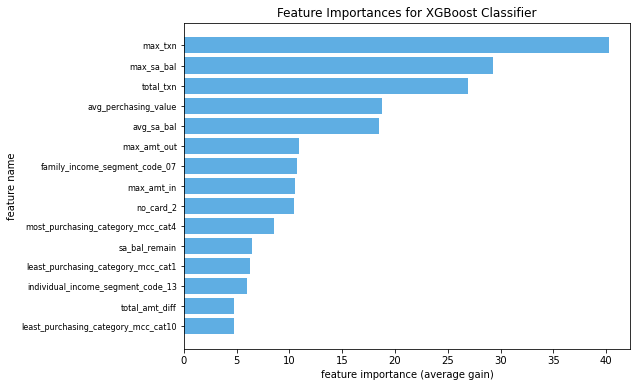

In [177]:
# feature importance
feature_map = model.get_booster().get_score(importance_type='gain')
feature_map_sort = dict(sorted(feature_map.items(), key=lambda item: item[1], reverse=True))
top = 15
plt.figure(figsize = (8,6))
plt.title("Feature Importances for XGBoost Classifier")
feature_importance_values = list(feature_map_sort.values())[:top]
feature_names = list(feature_map_sort.keys())[:top]
plt.barh(range(len(feature_importance_values), 0, -1), feature_importance_values, color = '#5FAEE3')
plt.yticks(range(len(feature_names), 0, -1), feature_names, fontsize = 8)
plt.xlabel('feature importance (average gain)')
plt.ylabel('feature name')
plt.show()

<a name='6'></a>
# 6 - Model Prediction

Prepare unseen data and predict those data using the previously trained XGBoost model

In [193]:
unseen_data = pd.read_csv(r'..\Data\y_test.csv', sep = ',')
unseen_data.user_id = unseen_data.user_id.astype('str')
unseen_data.head()

,user_id
0,40868
1,33358
2,11519
3,29934
4,39857


In [194]:
# unseen data aggregation
unseen_data = unseen_data.merge(cust_demo_data, left_on='user_id', right_on='user_id')
unseen_data['account_age'] = 2017 - unseen_data.account_start_date.dt.year
unseen_data['age'] = 2017 - unseen_data['birth_year']
unseen_data.drop(columns=['account_start_date', 'birth_year'], inplace = True, errors='ignore')
unseen_data = unseen_data.merge(card_info_agg, left_on='user_id', right_on='user_id')
unseen_data = reduce(lambda left,right: pd.merge(left, right, on=['user_id'], how='left'), [unseen_data, aggregate_trx_data, time_diff_data, last_txn_data, credit_util_data, frequent_spending, least_spending])
unseen_data = reduce(lambda left, right: pd.merge(left, right, on=['user_id'], how='left'), [unseen_data, sav_bal_agg, sav_bal_remain])
unseen_data = reduce(lambda left, right: pd.merge(left, right, on=['user_id'], how='left'), [unseen_data, max_amt, total_amt])
unseen_data.set_index('user_id', inplace=True)
# unseen data preprocessing
# - fill null
unseen_data.loc[:, ['marital_status', 'family_income_segment_code', 'individual_income_segment_code']] = unseen_data.loc[:, ['marital_status', 'family_income_segment_code', 'individual_income_segment_code']].fillna(value='Unknown')
# - convert data type
unseen_data.no_card = unseen_data.no_card.astype('str')
# - remove irrelevant columns
del unseen_data['max_credit_util'], unseen_data['mean_diff_txn_dt'], unseen_data['std_sa_bal']
# - preprocess categorical features
dummy_unseen_data = pd.DataFrame(encoder.transform(unseen_data[categorical_columns]).toarray(), 
                          columns = encoder.get_feature_names(categorical_columns),
                          index = unseen_data.index)
dummy_unseen_data.drop(columns = dummy_column_drop, inplace = True)
unseen_data = pd.concat([unseen_data, dummy_unseen_data], axis = 1)
unseen_data.drop(columns = categorical_columns, inplace = True)
# - preprocess numeric feaures
unseen_data.loc[:, numeric_columns] = scaler.transform(unseen_data.loc[:, numeric_columns])
unseen_data.head()

C:\Users\asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,account_age,age,total_cr_lmt_amt,total_txn,max_txn,count_txn,max_diff_txn_dt,day_since_last_txn,mean_credit_util,std_credit_util,...,least_purchasing_category_mcc_cat14,least_purchasing_category_mcc_cat15,least_purchasing_category_mcc_cat16,least_purchasing_category_mcc_cat2,least_purchasing_category_mcc_cat3,least_purchasing_category_mcc_cat5,least_purchasing_category_mcc_cat6,least_purchasing_category_mcc_cat7,least_purchasing_category_mcc_cat8,least_purchasing_category_mcc_cat9
user_id,,,,,,,,,,,,,,,,,,,,,
40868,-0.223507,-0.103995,0.763417,-0.709489,-0.973084,-0.149020,-0.552757,-0.694576,-1.300464,-0.969972,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
33358,0.081275,-0.534966,-0.879778,-0.918230,-1.011559,-0.525861,1.020499,-0.532884,0.279200,1.853706,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11519,-1.137856,-0.534966,-0.157731,-0.032313,0.696483,0.550828,0.346247,-0.856269,-0.350385,0.743805,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29934,-1.137856,-1.504651,-0.203309,0.346971,1.094066,-0.202855,-0.440381,0.113888,0.124491,0.377067,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
39857,0.233667,-1.073680,-0.253684,-0.272002,-0.303309,0.066318,0.233871,-0.694576,-0.134560,0.045690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [195]:
prediction_results = pd.DataFrame({'user_id': unseen_data.index.values.tolist(), 'predict': model.predict(unseen_data).tolist()})
prediction_results.head()

,user_id,predict
0,40868,0
1,33358,0
2,11519,0
3,29934,1
4,39857,0


In [196]:
prediction_results.to_csv(r'..\Data\prediction_results.csv', index=False)